# ANALISIS PREDIKSI STOCK MARKET
# Ujian Akhir Semester - Presentasi dan Visualisasi Data

Pada analisis ini dataset yang digunakan berasal dari Yahoo Finance. Dataset berisi harga harian untuk indeks bursa saham global (Amerika Serikat, Tiongkok, Kanada, Jerman, Jepang, dan lainnya) selama beberapa dekade. Adapun tujuan analisis ini adalah membangun sistem prediksi harga saham untuk 60 hari ke depan dihitung dari tanggal terakhir yang tersedia pada dataset.

Analisis dilakukan dalam 2 tahapan yaitu:
1. EDA dan validasi model (Notebook): Berfokus pada analisa secara mendalam pada 1 indeks utama dengan tujuan menemukan model terbaik dengan error terendah.

2. Implementasi dan skalabilitas (Streamlit): Model terbaik yang terpilih dari tahap pertama diimplementasikan ke dalam aplikasi web interaktif. Hal ini memungkinkan metode prediksi diterapkan secara otomatis ke seluruh indeks saham lainnya (seperti IXIC, HSI) sesuai pilihan pengguna.

## Import Libraries

In [27]:
# Import semua library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi yang konsisten
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

## Load Data & Initial Exploration

In [28]:
# Load data asli (9 kolom: Index, Date, Open, High, Low, Close, Adj Close, Volume, CloseUSD)
df = pd.read_csv('../dataset/indexProcessed.csv')
df['Date'] = pd.to_datetime(df['Date'])

print("="*70)
print("INFORMASI DATASET")
print("="*70)
print(f"Dataset dimuat dengan {df.shape[1]} kolom asli")
print(f"Jumlah records: {len(df)} baris")
print(f"Periode data: {df['Date'].min().date()} hingga {df['Date'].max().date()}")
print(f"Total tahun: {(df['Date'].max() - df['Date'].min()).days / 365.25:.1f} tahun")
print("\nKolom yang tersedia:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")

print("\n" + "="*70)
print("PREVIEW DATA (5 baris pertama)")
print("="*70)
print(df.head())

print("\n" + "="*70)
print("STATISTIK DESKRIPTIF")
print("="*70)
print(df.describe())

# Cek missing values
print("\n" + "="*70)
print("CEK MISSING VALUES")
print("="*70)
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "✓ Tidak ada missing values")

INFORMASI DATASET
Dataset dimuat dengan 9 kolom asli
Jumlah records: 104224 baris
Periode data: 1965-01-05 hingga 2021-06-03
Total tahun: 56.4 tahun

Kolom yang tersedia:
  1. Index
  2. Date
  3. Open
  4. High
  5. Low
  6. Close
  7. Adj Close
  8. Volume
  9. CloseUSD

PREVIEW DATA (5 baris pertama)
  Index       Date     Open     High      Low    Close  Adj Close  Volume  \
0   HSI 1986-12-31 2,568.30 2,568.30 2,568.30 2,568.30   2,568.30    0.00   
1   HSI 1987-01-02 2,540.10 2,540.10 2,540.10 2,540.10   2,540.10    0.00   
2   HSI 1987-01-05 2,552.40 2,552.40 2,552.40 2,552.40   2,552.40    0.00   
3   HSI 1987-01-06 2,583.90 2,583.90 2,583.90 2,583.90   2,583.90    0.00   
4   HSI 1987-01-07 2,607.10 2,607.10 2,607.10 2,607.10   2,607.10    0.00   

   CloseUSD  
0    333.88  
1    330.21  
2    331.81  
3    335.91  
4    338.92  

STATISTIK DESKRIPTIF
                                Date       Open       High        Low  \
count                         104224 104,224.00 104,2

Dataset menunjukkan memiliki rentang historis yang sangan panjang yaitu 56.4 tahun (Januari 1965 - Juni 2021). Selain itu tidak ditemukan missing values sehingga tidak perlu dilakukan imputasi data.

### Comparison Between Index

In [29]:
# Penilaian setiap index menggunakan 4 kriteria:
# a. Data Length (Seberapa panjang sejarahnya?)
#    -> Diukur menggunakan Start Year dan Duration (Years). Semakin panjang durasi data historis,
#       semakin stabil pola jangka panjang yang dapat dipelajari oleh model.

# b. Data Size (Seberapa banyak observasi?)
#    -> Diukur menggunakan Total Data. Jumlah observasi yang besar memberikan data pelatihan
#       yang cukup dan mengurangi risiko overfitting.

# c. Volatility (Seberapa stabil pasarnya?)
#    -> Diukur menggunakan Volatility (%). Indeks dengan volatilitas moderat cenderung
#       lebih mudah diprediksi karena tingkat noise yang lebih rendah.

# d. Liquidity (Seberapa aktif perdagangannya?)
#    -> Diukur menggunakan Avg Volume. Likuiditas yang stabil mencerminkan pasar yang aktif,
#       namun hanya digunakan sebagai faktor pendukung dalam pemilihan indeks.

stats_list = []

# Untuk setiap index:
for idx in df['Index'].unique():
    subset = df[df['Index'] == idx].sort_values('Date')
    
    # Hitung Durasi (Tahun)
    duration = (subset['Date'].max() - subset['Date'].min()).days / 365.25
    
    # Hitung Volatilitas (Standar Deviasi dari Daily Return)
    # Return dalam persen (%) biar adil karena mata uang beda-beda
    daily_return = subset['Close'].pct_change()
    volatility = daily_return.std() * 100 
    
    stats_list.append({
        'Index': idx,
        'Start Year': subset['Date'].min().year,
        'Duration (Years)': round(duration, 1),
        'Avg Volume': subset['Volume'].mean(),
        'Volatility (%)': round(volatility, 3),
        'Total Data': len(subset)
    })

comp_df = pd.DataFrame(stats_list).sort_values('Avg Volume', ascending=False) # Urutkan dari Volume Tertinggi
pd.options.display.float_format = '{:,.2f}'.format

print("=== TABEL PERBANDINGAN INDEX ===")
display(comp_df)

=== TABEL PERBANDINGAN INDEX ===


,Index,Start Year,Duration (Years),Avg Volume,Volatility (%),Total Data
7,GSPTSE,1979,41.90,"9,620,499,365.38",0.99,10526
1,NYA,1965,55.40,"1,215,565,480.75",1.02,13947
2,IXIC,1971,50.30,"991,528,335.70",1.25,12690
0,HSI,1986,34.40,"843,019,135.48",1.61,8492
5,N100,1999,21.40,"195,822,609.44",1.31,5474
9,GDAXI,1987,33.40,"68,303,838.95",1.41,8438
4,N225,1965,56.40,"39,762,887.49",1.27,13874
10,SSMI,1990,30.50,"36,466,311.34",1.13,7671
11,TWII,1997,23.90,"2,457,310.92",1.38,5869
6,399001.SZ,1997,23.80,"250,027.12",1.75,5760


Berdasarkan evaluasi durasi data historis, jumlah observasi, dan tingkat volatilitas, indeks NYA dipilih sebagai indeks utama dalam analisis ini. NYA memiliki durasi data yang panjang (55,4 tahun), jumlah observasi terbesar (13.947 data), serta volatilitas yang relatif stabil (1,02%), sehingga bisa memberikan basis pelatihan yang kuat dan konsisten untuk membangun model prediksi time series. 

In [30]:
# Filter data menjadi NYA
data = df[df.Index == 'NYA'].copy() 
data = data.sort_values('Date').set_index('Date')

print("Fokus Analisis: NYA (New York Stock Exchange)")
print(f"Total Data: {len(data)} hari")

Fokus Analisis: NYA (New York Stock Exchange)
Total Data: 13947 hari


## 1. EDA

### Visualisasi 1: Time Series Multi-Line Plot

**Jenis Plot**: Multi-Line Plot + Bar Chart

**JUSTIFIKASI:**
Line plot adalah pilihan terbaik untuk data time series karena dapat 
menunjukkan tren, pola, dan perubahan nilai sepanjang waktu secara kontinyu.
Bar chart untuk volume memudahkan identifikasi periode trading yang aktif.

**AESTHETICS & MAPPING:**
1. X-axis (Position) → Date (Temporal/Continuous)
   Mapping: Waktu dipetakan ke posisi horizontal
   
2. Y-axis (Position) → Price & Volume (Continuous Numerical)
   Mapping: Nilai harga/volume dipetakan ke posisi vertikal
   
3. Color (Hue) → Variable Type (Discrete/Categorical)
   Mapping: Setiap variabel (Open/Close/MA) diberi warna berbeda
   
4. Line Style → Data Type (Discrete)
   Mapping: Data aktual (solid), Moving Average (dashed)

**PEMILIHAN WARNA (Double Hue - Discrete):**

- Biru (#1f77b4) = Close → Warna utama, karena Close adalah harga paling penting

- Oranye (#ff7f0e) = Open → Warna komplementer, mudah dibedakan dari biru

- Hijau (#2ca02c) = MA-50 → Trend jangka pendek

- Merah (#d62728) = MA-200 → Trend jangka panjang

- Ungu (#9467bd) = Volume → Warna terpisah untuk data berbeda

Alasan Discrete Color: Karena membandingkan kategori yang berbeda.

(Open vs Close vs MA), bukan gradient nilai continuous.

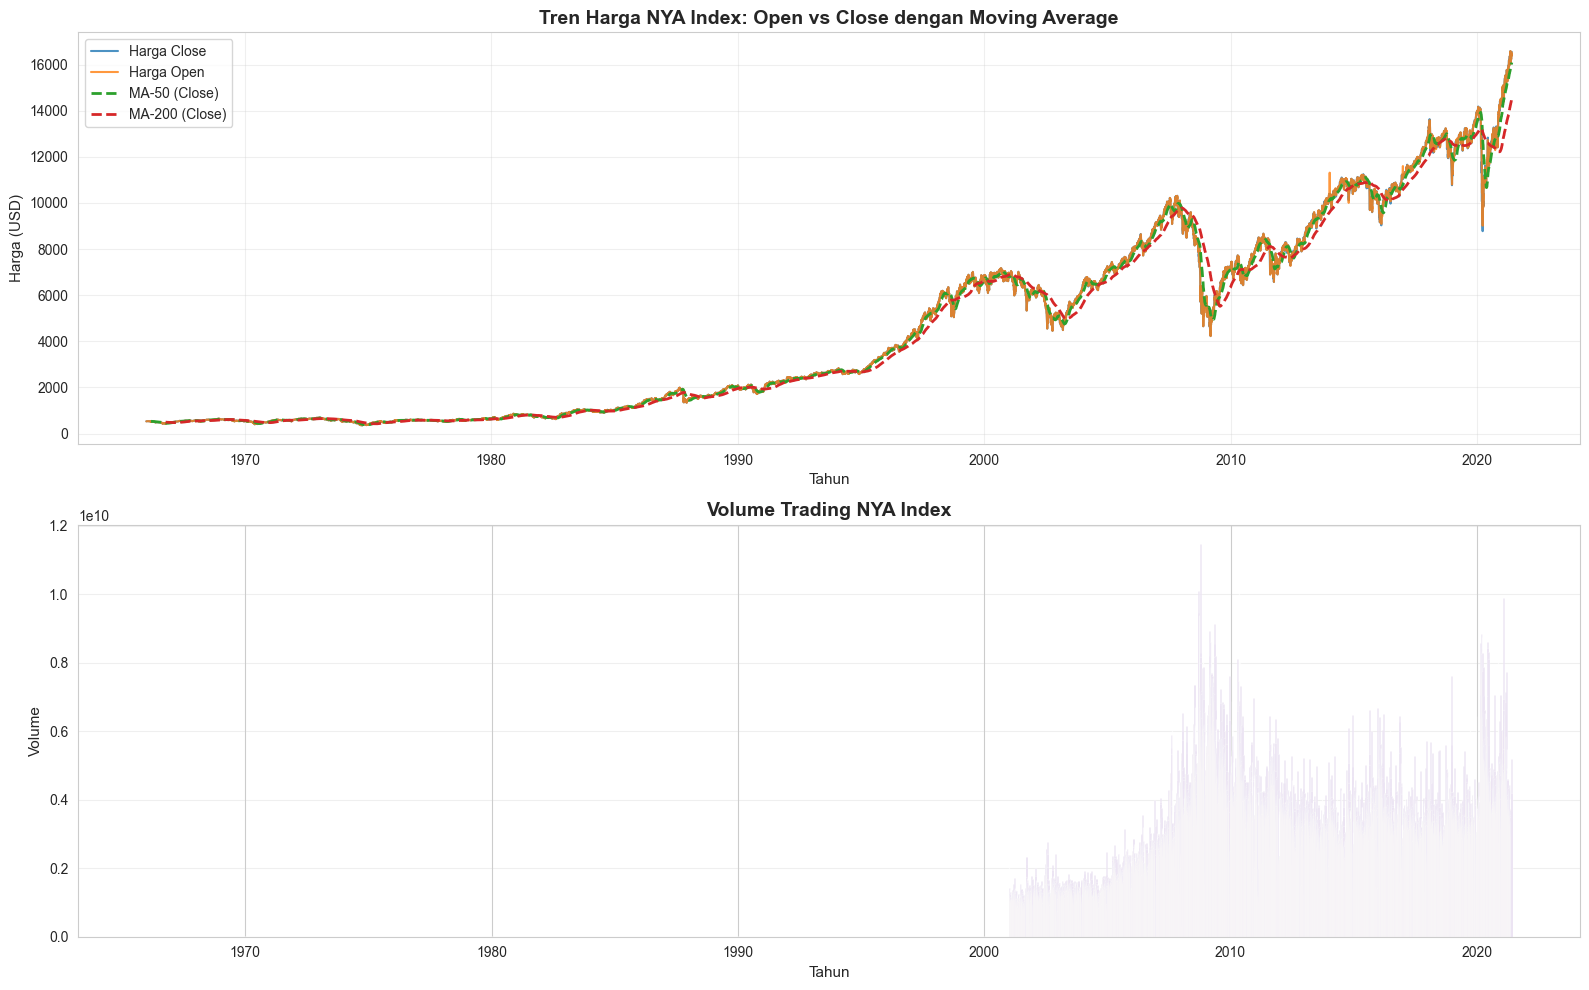

In [31]:
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Subplot 1: Harga Close & Open dengan Moving Average
ax1.plot(data.index, data['Close'], label='Harga Close', color='#1f77b4', linewidth=1.5, alpha=0.8)
ax1.plot(data.index, data['Open'], label='Harga Open', color='#ff7f0e', linewidth=1.5, alpha=0.8)
ax1.plot(data.index, data['Close'].rolling(window=50).mean(), 
         label='MA-50 (Close)', color='#2ca02c', linewidth=2, linestyle='--')
ax1.plot(data.index, data['Close'].rolling(window=200).mean(), 
         label='MA-200 (Close)', color='#d62728', linewidth=2, linestyle='--')
ax1.set_title('Tren Harga NYA Index: Open vs Close dengan Moving Average', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tahun', fontsize=11)
ax1.set_ylabel('Harga (USD)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Subplot 2: Volume Trading
ax2.bar(data.index, data['Volume'], color='#9467bd', alpha=0.6, width=10)
ax2.set_title('Volume Trading NYA Index', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tahun', fontsize=11)
ax2.set_ylabel('Volume', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


**INSIGHT** (blm selesai):
- Trend Jangka Panjang: Harga cenderung naik
- Volatilitas: Fluktuasi Harga cukup berfluktuasi
- Pattern: 
- Volume Correlation: 

### 2. Visualisasi 2: Distribusi Harga & Return

**Jenis Plot**: Histogram + Kernel Density Estimation (KDE)

**JUSTIFIKASI**:
Histogram menunjukkan frekuensi distribusi data, sementara KDE memberikan 
smooth curve untuk melihat bentuk distribusi secara keseluruhan.

**AESTHETICS & MAPPING**:
1. X-axis (Position) → Harga/Return (Continuous)
2. Y-axis (Position) → Frequency Density (Continuous)
3. Color (Hue) → Histogram vs KDE (Discrete)
4. Transparency (Alpha) → Layering (0.6 untuk histogram)

**PEMILIHAN WARNA**:
- Biru/Hijau (histogram) = Discrete color untuk bars
- Merah (KDE line) = Kontras tinggi untuk visibility


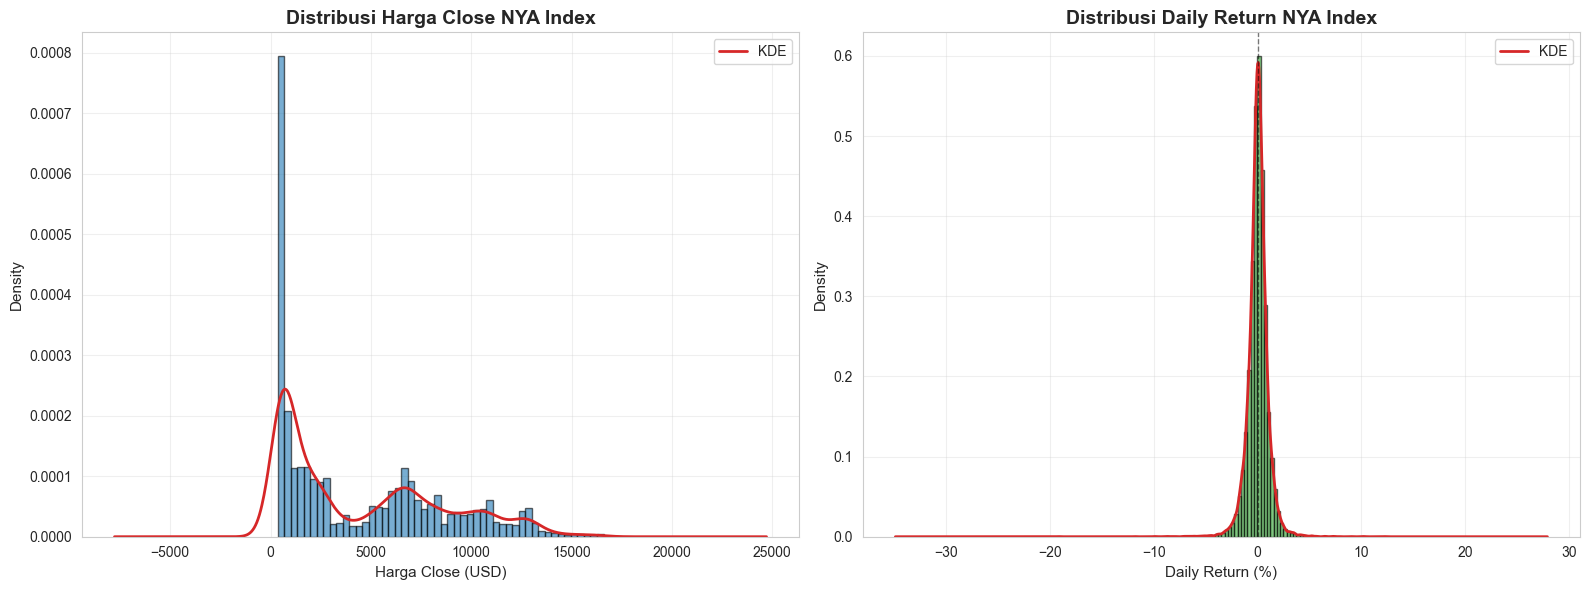


STATISTIK DAILY RETURN:
• Mean Return: 0.0300%
• Std Deviation: 1.0245%
• Skewness: -0.7189
• Kurtosis: 20.7682
• Min Return: -19.17%
• Max Return: 12.22%

INTERPRETASI:
- Skewness negatif: Distribusi condong ke kiri (more downside)
- Kurtosis >3: Fat tails (lebih banyak extreme events)



In [32]:
# Hitung daily return
data['Daily_Return'] = data['Close'].pct_change() * 100

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Histogram + KDE untuk Harga Close
axes[0].hist(data['Close'], bins=50, color='#1f77b4', alpha=0.6, edgecolor='black', density=True)
data['Close'].plot(kind='kde', ax=axes[0], color='#d62728', linewidth=2, label='KDE')
axes[0].set_title('Distribusi Harga Close NYA Index', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Harga Close (USD)', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Subplot 2: Histogram + KDE untuk Daily Return
axes[1].hist(data['Daily_Return'].dropna(), bins=100, color='#2ca02c', alpha=0.6, edgecolor='black', density=True)
data['Daily_Return'].plot(kind='kde', ax=axes[1], color='#d62728', linewidth=2, label='KDE')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_title('Distribusi Daily Return NYA Index', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Daily Return (%)', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistik return
print(f"""
STATISTIK DAILY RETURN:
• Mean Return: {data['Daily_Return'].mean():.4f}%
• Std Deviation: {data['Daily_Return'].std():.4f}%
• Skewness: {data['Daily_Return'].skew():.4f}
• Kurtosis: {data['Daily_Return'].kurtosis():.4f}
• Min Return: {data['Daily_Return'].min():.2f}%
• Max Return: {data['Daily_Return'].max():.2f}%

INTERPRETASI:
- Skewness {'positif' if data['Daily_Return'].skew() > 0 else 'negatif'}: Distribusi {'condong ke kanan (more upside)' if data['Daily_Return'].skew() > 0 else 'condong ke kiri (more downside)'}
- Kurtosis {'>3' if data['Daily_Return'].kurtosis() > 3 else '<3'}: {'Fat tails (lebih banyak extreme events)' if data['Daily_Return'].kurtosis() > 3 else 'Normal distribution'}
""")

### Visualisasi 3: Boxplot Outlier Detection

**Jenis Plot**: Boxplot (Box-and-Whisker Plot)

**JUSTIFIKASI**:
Boxplot adalah pilihan terbaik untuk mendeteksi outliers dan memahami 
distribusi data dalam kelompok kategorikal (dekade).

**AESTHETICS & MAPPING**:
1. X-axis (Position) → Decade (Discrete/Categorical)
2. Y-axis (Position) → Price/Return (Continuous)
3. Box components:
   - Box = Interquartile Range (IQR, Q1-Q3)
   - Line in box = Median (Q2)
   - Whiskers = 1.5 × IQR dari Q1/Q3
   - Points = Outliers

**PEMILIHAN WARNA**:
- Default matplotlib colors (discrete) untuk setiap dekade
- Red line pada y=0 untuk referensi return netral

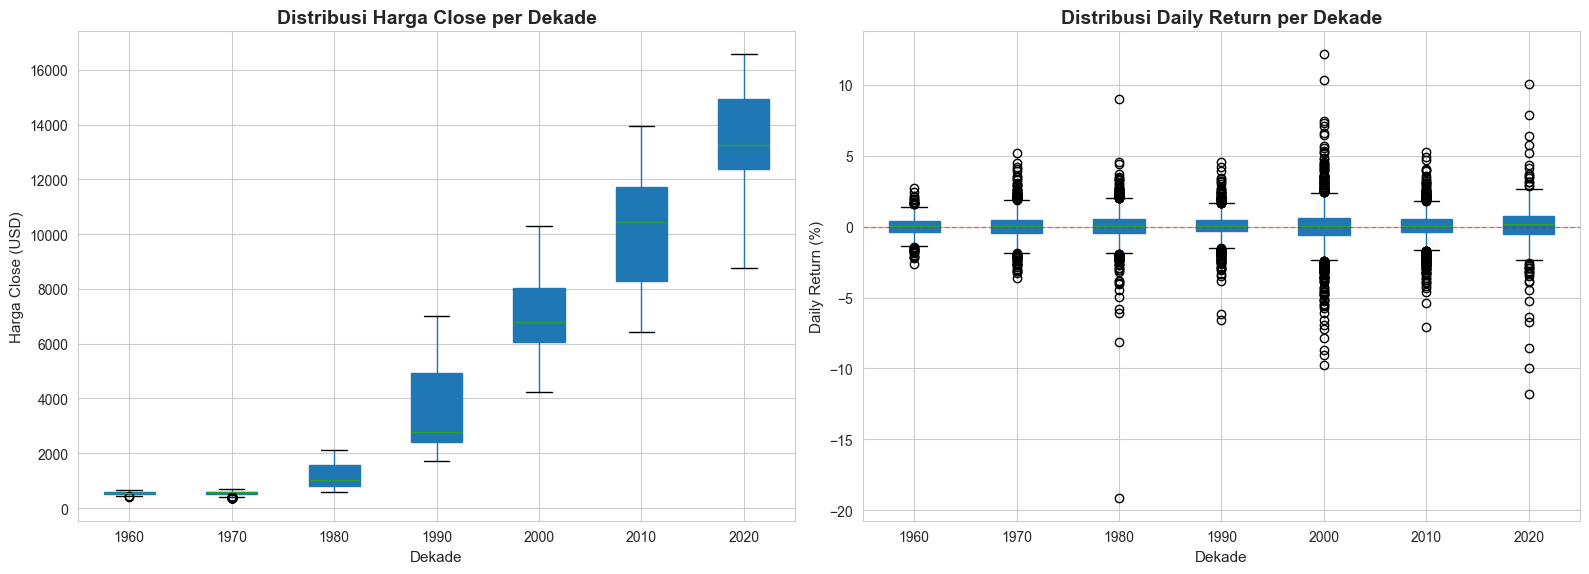

In [33]:
# Tambahkan kolom decade
data['Decade'] = (data.index.year // 10) * 10

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Boxplot Harga per Dekade
data.boxplot(column='Close', by='Decade', ax=axes[0], patch_artist=True)
axes[0].set_title('Distribusi Harga Close per Dekade', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dekade', fontsize=11)
axes[0].set_ylabel('Harga Close (USD)', fontsize=11)
axes[0].get_figure().suptitle('')  

# Subplot 2: Boxplot Daily Return per Dekade
data.boxplot(column='Daily_Return', by='Decade', ax=axes[1], patch_artist=True)
axes[1].set_title('Distribusi Daily Return per Dekade', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Dekade', fontsize=11)
axes[1].set_ylabel('Daily Return (%)', fontsize=11)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].get_figure().suptitle('')  

plt.tight_layout()
plt.show()

### Uji Stationarity (Syarat Utama Model Arima)

In [34]:
def test_stationarity(timeseries, title):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries.dropna(), autolag='AIC')
    
    print(f'\n{title}')
    print('─' * 60)
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    # Interpretasi
    if result[1] <= 0.05:
        print(f"\n✓ STASIONER (p-value ≤ 0.05)")
        print(f"  Data TIDAK memiliki unit root, cocok untuk ARIMA")
    else:
        print(f"\n✗ NON-STASIONER (p-value > 0.05)")
        print(f"  Data memiliki unit root, perlu differencing")
    
    return result

# Test pada harga Close (level)
result_close = test_stationarity(data['Close'], 'HARGA CLOSE (Level)')

# Test pada first difference
data['Close_Diff'] = data['Close'].diff()
result_diff = test_stationarity(data['Close_Diff'], 'HARGA CLOSE (First Difference)')

print(f"""
{"="*70}
KESIMPULAN UJI STASIONERITAS:
{"="*70}
Harga Close dalam level adalah {'STASIONER' if result_close[1] <= 0.05 else 'NON-STASIONER'}.
Setelah differencing (d=1), data menjadi {'STASIONER' if result_diff[1] <= 0.05 else 'NON-STASIONER'}.

Implikasi untuk ARIMA:
- Parameter 'd' (differencing) yang optimal: {0 if result_close[1] <= 0.05 else 1}
- Model ARIMA harus menggunakan differencing untuk mengatasi trend
""")


HARGA CLOSE (Level)
────────────────────────────────────────────────────────────
ADF Statistic: 1.287155
p-value: 0.996536
Critical Values:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✗ NON-STASIONER (p-value > 0.05)
  Data memiliki unit root, perlu differencing

HARGA CLOSE (First Difference)
────────────────────────────────────────────────────────────
ADF Statistic: -17.487975
p-value: 0.000000
Critical Values:
  1%: -3.431
  5%: -2.862
  10%: -2.567

✓ STASIONER (p-value ≤ 0.05)
  Data TIDAK memiliki unit root, cocok untuk ARIMA

KESIMPULAN UJI STASIONERITAS:
Harga Close dalam level adalah NON-STASIONER.
Setelah differencing (d=1), data menjadi STASIONER.

Implikasi untuk ARIMA:
- Parameter 'd' (differencing) yang optimal: 1
- Model ARIMA harus menggunakan differencing untuk mengatasi trend



### Visualisasi 4: ACF & PACF Plots

**Jenis Plot**: Autocorrelation Plot (Stem Plot)

**JUSTIFIKASI**:
ACF & PACF adalah tool standar untuk time series analysis, khususnya untuk:
1. Mendeteksi pola autoregressive (AR) dan moving average (MA)
2. Menentukan parameter optimal untuk model ARIMA (p, d, q)

**AESTHETICS & MAPPING**:
1. X-axis (Position) → Lag (Discrete: 0, 1, 2, ..., 40)
2. Y-axis (Position) → Correlation Coefficient (Continuous: -1 to 1)
3. Blue shaded area → Confidence interval (95%)
4. Vertical lines → Correlation strength at each lag

**PEMILIHAN WARNA**:
- Blue bars (discrete) = Correlation values
- Blue shaded area (continuous) = Confidence interval


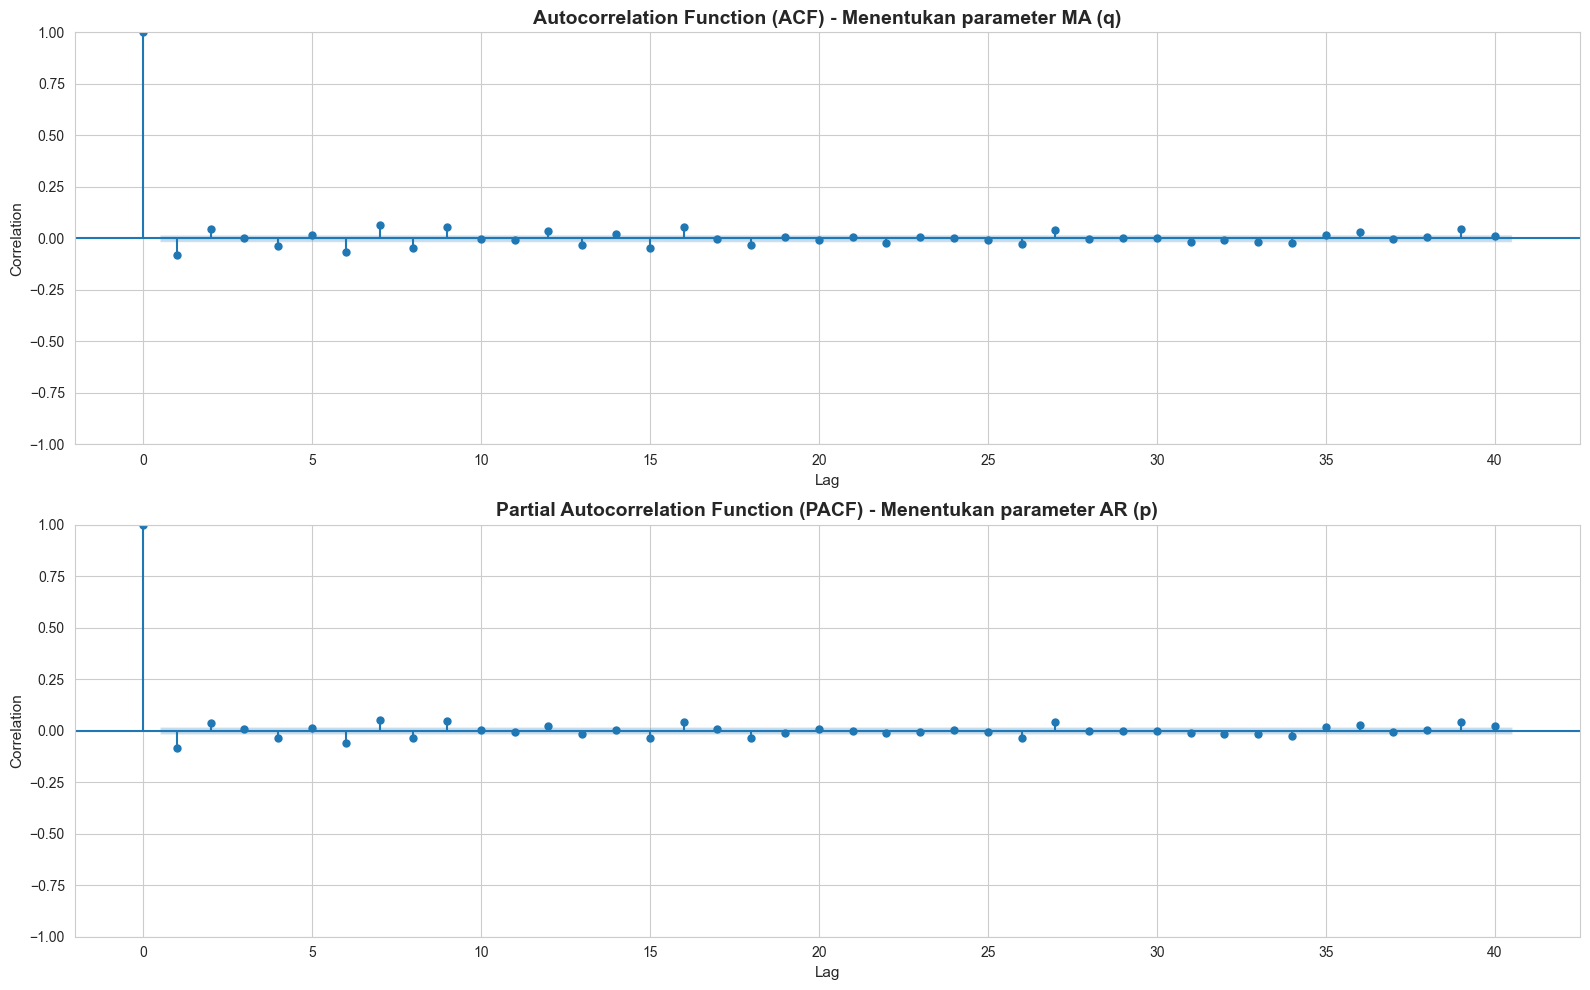

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot ACF
plot_acf(data['Close_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) - Menentukan parameter MA (q)', 
                   fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=11)
axes[0].set_ylabel('Correlation', fontsize=11)

# Plot PACF
plot_pacf(data['Close_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) - Menentukan parameter AR (p)', 
                   fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=11)
axes[1].set_ylabel('Correlation', fontsize=11)

plt.tight_layout()
plt.show()

### Visualisasi 5: Heatmap Korelasi Antar Fitur

**Jenis Plot**: Heatmap (Matrix Plot)

**JUSTIFIKASI**:
Heatmap adalah pilihan terbaik untuk visualisasi matrix korelasi karena:
1. Dapat menampilkan banyak variabel sekaligus (8+ kolom)
2. Color intensity langsung menunjukkan kekuatan korelasi
3. Mudah mengidentifikasi pola korelasi dalam satu pandangan

**AESTHETICS & MAPPING**:
1. X-axis & Y-axis (Position) → Feature Names (Categorical)
   Mapping: Setiap cell mewakili korelasi antara 2 fitur
   
2. Color (Intensity) → Correlation Coefficient (Continuous: -1 to +1)
   Mapping: Nilai korelasi dipetakan ke color gradient
   
3. Annotations (Text) → Exact correlation values

**PEMILIHAN WARNA (Continuous Diverging)**:
• RdYlGn (Red-Yellow-Green) dipilih karena:
  - RED (-1.0): Korelasi negatif sempurna
  - YELLOW (0.0): Tidak ada korelasi
  - GREEN (+1.0): Korelasi positif sempurna
  - Center=0: Warna diverging dari center point

Alasan Continuous Color: Karena correlation coefficient adalah nilai continuous dari -1 hingga +1, bukan kategori diskrit.

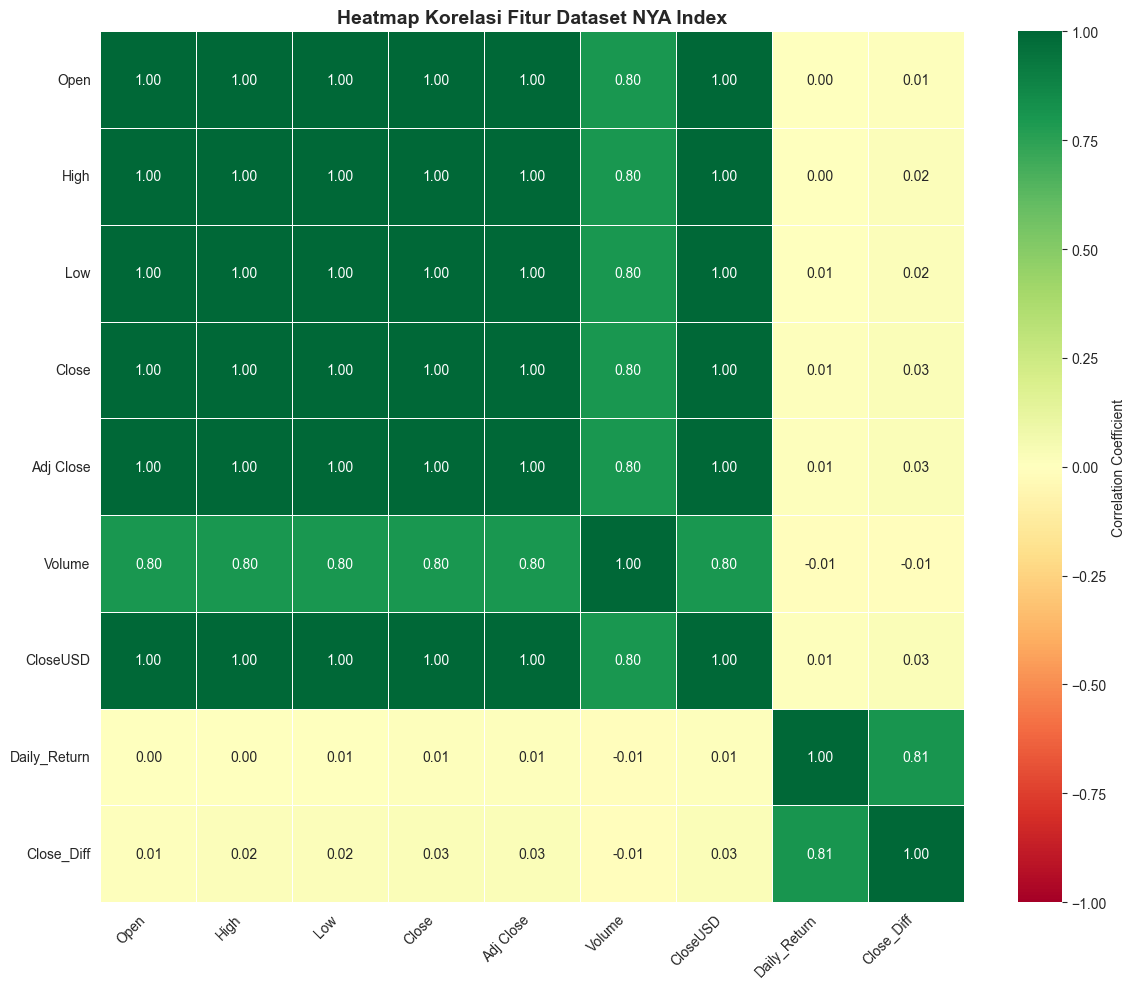

PASANGAN FITUR DENGAN KORELASI SANGAT TINGGI (>0.95):
────────────────────────────────────────────────────────────
• Open <-> High: 1.0000
• Open <-> Low: 0.9999
• Open <-> Close: 0.9999
• Open <-> Adj Close: 0.9999
• Open <-> CloseUSD: 0.9999
• High <-> Low: 0.9999
• High <-> Close: 0.9999
• High <-> Adj Close: 0.9999
• High <-> CloseUSD: 0.9999
• Low <-> Close: 1.0000
• Low <-> Adj Close: 1.0000
• Low <-> CloseUSD: 1.0000
• Close <-> Adj Close: 1.0000
• Close <-> CloseUSD: 1.0000
• Adj Close <-> CloseUSD: 1.0000


In [36]:
# Drop kolom non-numerik untuk korelasi
data_for_corr = data.drop(['Decade'], axis=1, errors='ignore')

plt.figure(figsize=(12, 10))

# Menghitung korelasi hanya untuk kolom numerik
corr_matrix = data_for_corr.corr(numeric_only=True)


# Membuat Heatmap dengan skema warna RdYlGn (Red-Yellow-Green)
sns.heatmap(corr_matrix,
            annot=True,
            cmap='RdYlGn',
            center=0,
            vmin=-1,
            vmax=1,
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Heatmap Korelasi Fitur Dataset NYA Index', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Analisis korelasi tertinggi
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

print("PASANGAN FITUR DENGAN KORELASI SANGAT TINGGI (>0.95):")
print("─" * 60)
for col1, col2, corr_val in high_corr_pairs:
    print(f"• {col1} <-> {col2}: {corr_val:.4f}")


**PENJELASAN:**
Open, High, Low, Close, dan Adj Close memiliki korelasi sangat tinggi (>0.99) karena mereka semua adalah harga saham pada hari yang sama:
- Open: Harga pembukaan
- High: Harga tertinggi hari itu
- Low: Harga terendah hari itu
- Close: Harga penutupan
- Adj Close: Close yang disesuaikan dengan corporate actions

Korelasi sempurna ini NORMAL dan EXPECTED dalam data stock market.

Volume biasanya memiliki korelasi lebih rendah dengan harga karena:
- Volume adalah jumlah saham yang diperdagangkan
- Tidak selalu bergerak searah dengan harga
- High volume bisa terjadi saat harga naik ATAU turun

**IMPLIKASI UNTUK MODELING**:
- Untuk prediksi, cukup gunakan satu fitur harga (Close) karena redundansi tinggi
- Volume bisa ditambahkan sebagai feature engineering jika diperlukan
- Multicollinearity tidak masalah untuk LSTM, tapi bisa jadi issue untuk linear models

### Visualisasi 6: Heatmap Seasonality

Alasan menggunakan heatmap ini karena ingin menditeksi pola musiman (seasonality) pada indeks NYA, yaitu untuk mengidentifikasi apakah terdapat bulan-bulan tertentu yang secara konsisten menghasilkan return positif (untung) atau negatif (rugi) dari tahun ke tahun. Visualisasi ini memudahkan pengamatan pola temporal dua dimensi (bulan dan tahun) yang sulit ditangkap hanya dengan grafik time series biasa.

Aesthetics yang digunakan:
1. Sumbu X: Mewakili bulan Januari - Desember (1-12)
2. Sumbu Y: Mewakili tahun
3. Warna mewakili: Avg daily return dari index NYA. Warna digunakan sebagai continuous aesthetic karena nilai avg daily return bersifat numerik kontinu. Skema warna double hue (merah–kuning–hijau) digunakan untuk membedakan return negatif (merah) dan return positif (hijau), sehingga kondisi rugi dan untung dapat diinterpretasikan secara intuitif pada setiap periode waktu.


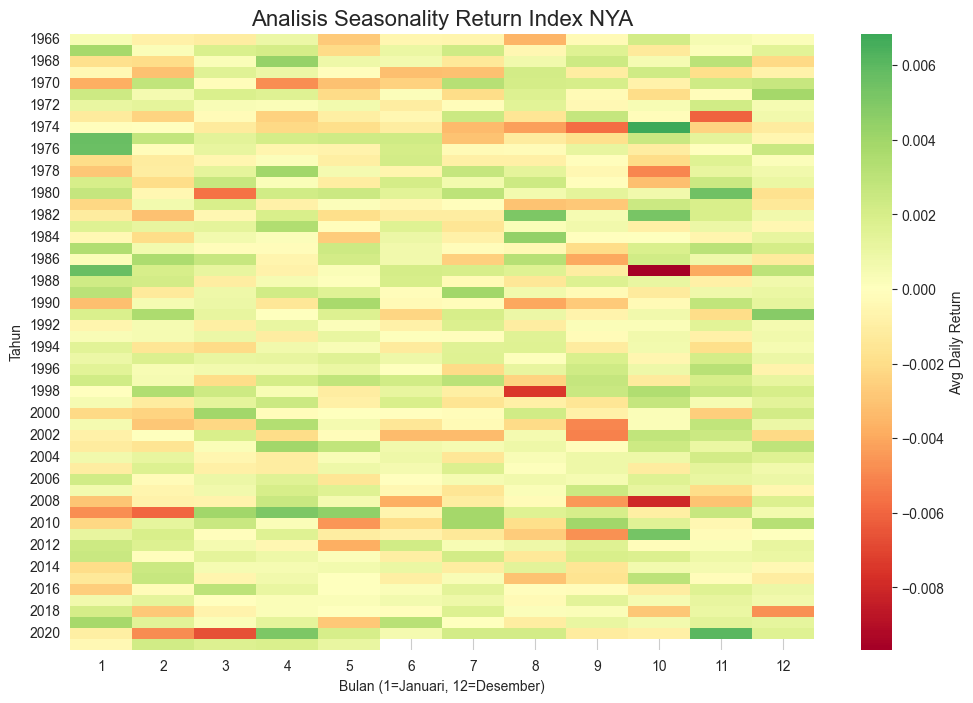

In [37]:
df_heatmap = data.copy()
df_heatmap['Year'] = df_heatmap.index.year
df_heatmap['Month'] = df_heatmap.index.month
df_heatmap['Return'] = df_heatmap['Close'].pct_change()

# Pivot Table: Baris=Tahun, Kolom=Bulan, Isi=Rata-rata Return
pivot_table = df_heatmap.pivot_table(values='Return', index='Year', columns='Month', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='RdYlGn', center=0, annot=False, cbar_kws={'label': 'Avg Daily Return'})
plt.title('Analisis Seasonality Return Index NYA', fontsize=16)
plt.xlabel('Bulan (1=Januari, 12=Desember)')
plt.ylabel('Tahun')
plt.show()

Berdasarkan hasil visualisasi avg daily return index NYA, tidak ditemukan pola musiman yang konsisten di mana bulan tertentu secara stabil memberikan return positif atau negatif dari tahun ke tahun. Warna pada heatmap menunjukkan variasi return yang cukup tinggi antar tahun untuk bulan yang sama, menandakan bahwa performa bulanan cenderung dipengaruhi oleh kondisi pasar spesifik pada periode tertentu, bukan oleh efek musiman yang berulang. Maka dari itu, seasonality pada indeks NYA bersifat lemah dan tidak dapat dijadikan dasar dalam menentukan waktu investasi.

Jadi model musiman seperti SARIMA akan tidak digunakan, dan analisis difokuskan pada pemodelan dinamika jangka pendek menggunakan ARIMA, LSTM, dan GRU.

## Preprocessing

### Untuk LSTM & Gated Recurrent Unit (GRU)

In [38]:
# Ambil kolom Close
dataset = data[['Close']].values
print(f"Total data points: {len(dataset)}")

# # Normalisasi menggunakan MinMaxScaler (0-1 range)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(dataset)
# print(f"✓ Data dinormalisasi ke range [0, 1]")

# # Data testing untuk sekitar 5 tahun terakhir
# test_days = 1250 
# train_size = len(scaled_data) - test_days

# # Hitung ulang split
# train_data = scaled_data[:train_size]
# test_data = scaled_data[train_size:]

train_size = len(dataset) - 1250
train_raw = dataset[:train_size]
test_raw = dataset[train_size:]

# 2. Fit Scaler hanya pada Training Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_raw)

# 3. Transform Test Data pakai scaler yang sudah dipelajari dari Training
test_data = scaler.transform(test_raw)
print(f"""
DATA SPLITTING:
• Training set: {len(train_data)} samples ({len(train_data)/len(dataset)*100:.1f}%)
• Testing set: {len(test_data)} samples ({len(test_data)/len(dataset)*100:.1f}%)
• Periode training: {data.index[0].date()} hingga {data.index[train_size-1].date()}
• Periode testing: {data.index[train_size].date()} hingga {data.index[-1].date()}
""")

# Membuat sliding window (60 hari untuk prediksi hari ke-61)
def create_window(dataset, window=60):
    """
    Membuat sequences untuk LSTM training
    
    Parameters:
    -----------
    dataset : array
        Data yang sudah dinormalisasi
    window : int
        Jumlah time steps untuk lookback period
        
    Returns:
    --------
    X : array shape (samples, window)
        Input sequences
    y : array shape (samples,)
        Target values
    """
    X, y = [], []
    for i in range(window, len(dataset)):
        X.append(dataset[i-window:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

window_size = 60  # Menggunakan 60 hari terakhir untuk prediksi hari berikutnya
print(f"Window size (lookback period): {window_size} hari")

X_train, y_train = create_window(train_data, window_size)
X_test, y_test = create_window(test_data, window_size)

print(f"""
HASIL WINDOWING:
• X_train shape: {X_train.shape} (samples, time_steps)
• y_train shape: {y_train.shape} (samples,)
• X_test shape: {X_test.shape} (samples, time_steps)
• y_test shape: {y_test.shape} (samples,)
""")

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"""
• X_train final shape: {X_train.shape} (samples, time_steps, features)
• X_test final shape: {X_test.shape} (samples, time_steps, features)
""")

Total data points: 13947

DATA SPLITTING:
• Training set: 12697 samples (91.0%)
• Testing set: 1250 samples (9.0%)
• Periode training: 1965-12-31 hingga 2016-06-10
• Periode testing: 2016-06-13 hingga 2021-05-28

Window size (lookback period): 60 hari

HASIL WINDOWING:
• X_train shape: (12637, 60) (samples, time_steps)
• y_train shape: (12637,) (samples,)
• X_test shape: (1190, 60) (samples, time_steps)
• y_test shape: (1190,) (samples,)


• X_train final shape: (12637, 60, 1) (samples, time_steps, features)
• X_test final shape: (1190, 60, 1) (samples, time_steps, features)



## Training Model

### Training LSTM (Deep Learning)

In [40]:
# Build LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

print("ARSITEKTUR MODEL:")
print("─" * 60)
model_lstm.summary()

print("\n" + "─" * 60)
print("PENJELASAN ARSITEKTUR:")
print("─" * 60)
print("""
1. LSTM Layer 1 (50 units, return_sequences=True):
   - Menangkap pola temporal jangka pendek-menengah
   - return_sequences=True agar output bisa diteruskan ke LSTM layer 2
   
2. Dropout Layer 1 (20%):
   - Mencegah overfitting dengan randomly drop 20% neurons
   
3. LSTM Layer 2 (50 units, return_sequences=False):
   - Menangkap pola temporal tingkat tinggi
   - return_sequences=False karena ini layer terakhir LSTM
   
4. Dropout Layer 2 (20%):
   - Additional regularization
   
5. Dense Layer 1 (25 units):
   - Fully connected layer untuk non-linear transformation
   
6. Dense Layer 2 (1 unit):
   - Output layer untuk single prediction value

OPTIMIZER: Adam (Adaptive learning rate)
LOSS FUNCTION: MSE (Mean Squared Error)
""")

# Early stopping untuk mencegah overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Memulai training...")
print("─" * 60)

# Training dengan validation split
history = model_lstm.fit(
    X_train, y_train, 
    batch_size=32, 
    epochs=50, 
    validation_split=0.2,  # 20% dari training data untuk validation
    callbacks=[early_stop],
    verbose=1
)

print(f"Best epoch: {len(history.history['loss']) - 5}")  # patience=5


ARSITEKTUR MODEL:
────────────────────────────────────────────────────────────


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)


────────────────────────────────────────────────────────────
PENJELASAN ARSITEKTUR:
────────────────────────────────────────────────────────────

1. LSTM Layer 1 (50 units, return_sequences=True):
   - Menangkap pola temporal jangka pendek-menengah
   - return_sequences=True agar output bisa diteruskan ke LSTM layer 2
   
2. Dropout Layer 1 (20%):
   - Mencegah overfitting dengan randomly drop 20% neurons
   
3. LSTM Layer 2 (50 units, return_sequences=False):
   - Menangkap pola temporal tingkat tinggi
   - return_sequences=False karena ini layer terakhir LSTM
   
4. Dropout Layer 2 (20%):
   - Additional regularization
   
5. Dense Layer 1 (25 units):
   - Fully connected layer untuk non-linear transformation
   
6. Dense Layer 2 (1 unit):
   - Output layer untuk single prediction value

OPTIMIZER: Adam (Adaptive learning rate)
LOSS FUNCTION: MSE (Mean Squared Error)

Memulai training...
────────────────────────────────────────────────────────────
Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━

#### Visualisasi 7: Training History (Loss Curve)

**Jenis Plot**: Line Plot (Loss Curve)

**JUSTIFIKASI**:
Loss curve adalah standar dalam deep learning untuk:
1. Monitoring training progress
2. Mendeteksi overfitting (training loss << validation loss)
3. Mendeteksi underfitting (both losses tetap tinggi)
4. Menentukan kapan training harus dihentikan

**AESTHETICS & MAPPING**:
1. X-axis (Position) → Epoch Number (Discrete/Sequential)
2. Y-axis (Position) → Loss Value (Continuous)
3. Color (Hue) → Dataset Type (Discrete: Train vs Validation)

**PEMILIHAN WARNA (Discrete)**:
- Biru = Training Loss
- Oranye = Validation Loss

**Alasan**: Standar industri, kontras tinggi untuk membedakan kedua lines

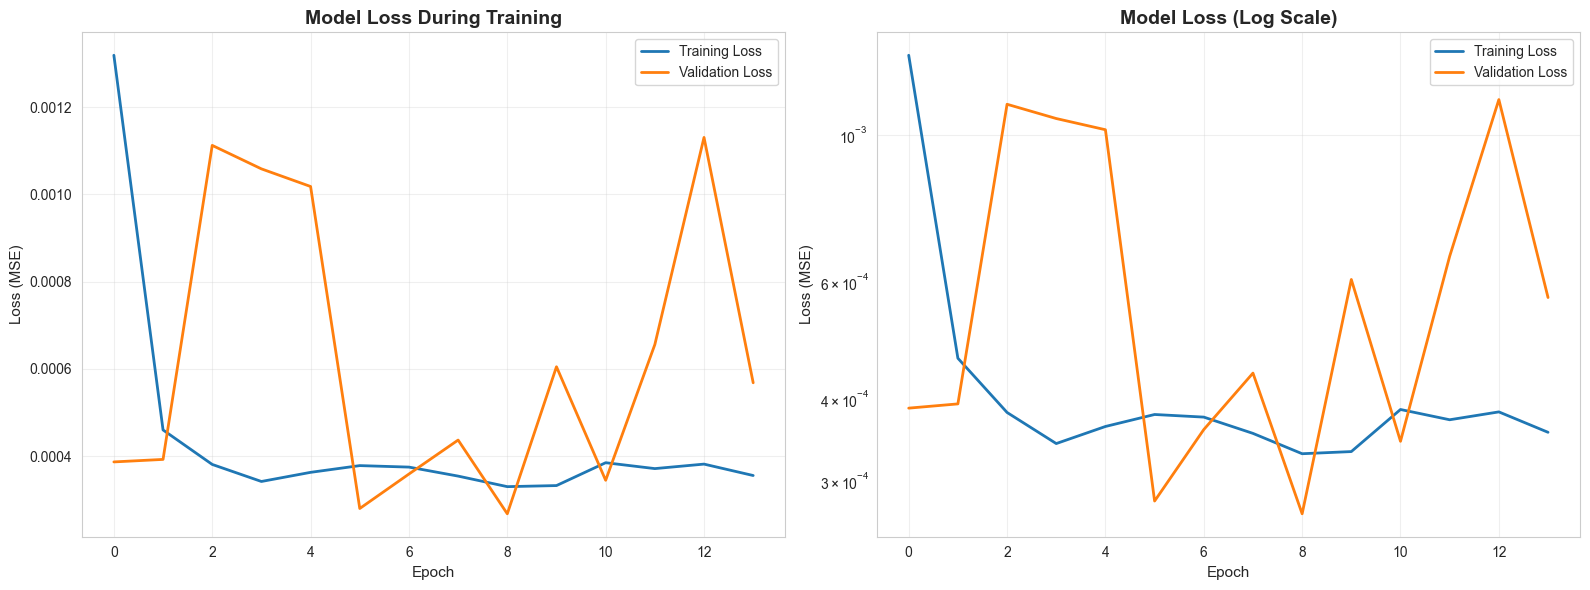

• Final Training Loss: 0.000356
• Final Validation Loss: 0.000568
• Gap: 0.000212

 Model OVERFIT: Gap besar antara training dan validation


In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e', linewidth=2)
plt.title('Model Loss During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss (MSE)', fontsize=11)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e', linewidth=2)
plt.title('Model Loss (Log Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss (MSE)', fontsize=11)
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretasi Hasil Model
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
loss_gap = abs(final_train_loss - final_val_loss)

print(f"• Final Training Loss: {final_train_loss:.6f}")
print(f"• Final Validation Loss: {final_val_loss:.6f}")
print(f"• Gap: {loss_gap:.6f}")

if loss_gap < final_train_loss * 0.1:
    print("\n Model BAIK: Gap kecil, tidak ada overfitting signifikan")
elif loss_gap < final_train_loss * 0.3:
    print("\n Model CUKUP: Ada sedikit overfitting, masih acceptable")
else:
    print("\n Model OVERFIT: Gap besar antara training dan validation")

### GRU

In [ ]:
model_gru = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')

print("ARSITEKTUR MODEL GRU:")
model_gru.summary()

early_stop_gru = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Memulai training GRU...")
print("─" * 60)

# Training GRU
history_gru = model_gru.fit(
    X_train, y_train, 
    batch_size=32, 
    epochs=50, 
    validation_split=0.2, 
    callbacks=[early_stop_gru],
    verbose=1
)

ARSITEKTUR MODEL GRU:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

Memulai training GRU...
────────────────────────────────────────────────────────────
Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - loss: 0.0019 - val_loss: 2.7781e-04
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - loss: 5.2395e-04 - val_loss: 1.9621e-04
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - loss: 3.8358e-04 - val_loss: 3.0566e-04
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - loss: 3.5452e-04 - val_loss: 1.9726e-04
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - loss: 4.0490e-04 - val_loss: 2.2543e-04
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - loss: 3.5243e-04 - val_loss: 5.9871e-04
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - loss: 3.5359e-04 - val_loss: 3.1040e-04


#### Line Plot Training Model Gru

Line plot ini digunakan untuk mengevaluasi proses pembelajaran model GRU selama training. Visualisasi ini diplih karena ingin tahu apakah model belajar stabil (loss menurun), mengalami overfitting (training loss turun tetapi validation loss naik), dan mengalami underfitting (training dan validation tinggi)

Aesthetics:
1. Sumbu X: Mewakili jumlah epoch selama proses training. Setiap titik pada sumbu X merepresentasikan satu kali proses pembaruan bobot model

2. Sumbu Y: Mewakili nilai loss (MSE) pada data training dan validation. Nilai loss yang lebih rendah menunjukkan performa model yang lebih baik

3. Warna: Digunakan untuk membedakan dua kategori data yang berbeda, yaitu training loss dan validation loss. Karena kedua data mewakili kategori diskrit, maka penggunaan warna diskrit. Skema warnanya adalah single hue per kategori (hijau untuk training, merah untuk validation) karena digunakan untuk perbandingan 2 kelompok data

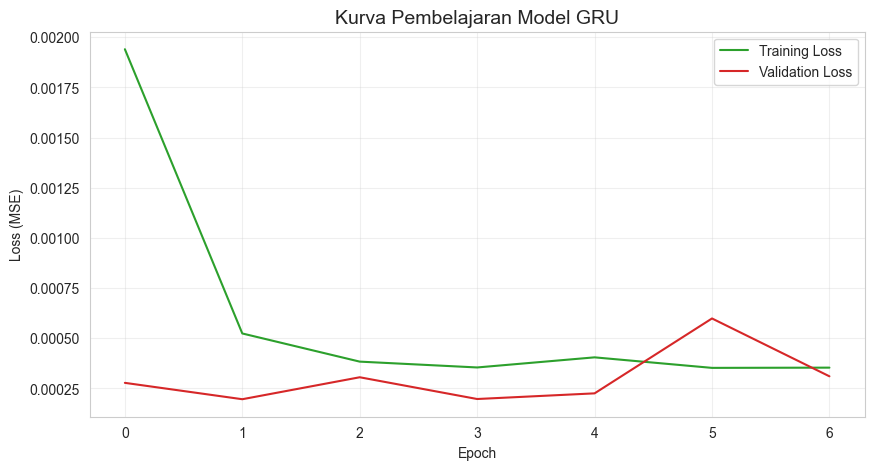

• Final GRU Train Loss: 0.00035
• Final GRU Val Loss:   0.00031


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_gru.history['loss'], label='Training Loss', color='#2ca02c')
plt.plot(history_gru.history['val_loss'], label='Validation Loss', color='#d62728')
plt.title('Kurva Pembelajaran Model GRU', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Cetak Hasil Akhir Saja
train_loss = history_gru.history['loss'][-1]
val_loss = history_gru.history['val_loss'][-1]
print(f"• Final GRU Train Loss: {train_loss:.5f}")
print(f"• Final GRU Val Loss:   {val_loss:.5f}")

Hasil training menunjukkan model GRU bisa belajar secara stabil dengan training dan validation loss yang relatif rendah serta tidak menunjukkan indikasi overfitting yang signifikan.

### ARIMA & Prediksi

In [ ]:
# Untuk ARIMA, kita pakai data asli (bukan scaled)
history = [x for x in data['Close'][:train_size]]
test_actual = data['Close'][train_size + window_size:]  # Samakan dengan LSTM test size

print(f"""
PARAMETER ARIMA(p, d, q):
─────────────────────────────────────────────────────────────────
• p (AR order): Jumlah lag observations yang digunakan
• d (Differencing): Jumlah differencing untuk stationarity  
• q (MA order): Size of moving average window

PARAMETER YANG DIPILIH: ARIMA(5, 1, 0)
• p=5: Berdasarkan PACF plot, signifikansi pada lag 1-5
• d=1: Berdasarkan ADF test, perlu 1x differencing
• q=0: Sederhana, cukup AR component untuk baseline

Note: Untuk production, gunakan auto_arima() untuk optimal selection
""")

arima_preds = []
arima_errors = []

print(f"\nMemulai Prediksi ARIMA...")
print(f"Total predictions to make: {len(test_actual)}")
print("─" * 60)

# Rolling prediction untuk ARIMA
for t in range(len(test_actual)):
    try:
        # Gunakan 200 data terakhir untuk efisiensi
        model_arima = ARIMA(history[-200:], order=(5, 1, 0))
        res = model_arima.fit()
        pred = res.forecast()[0]
        arima_preds.append(pred)
        history.append(test_actual.iloc[t])
        
        # Progress indicator
        if (t + 1) % 100 == 0:
            print(f"Progress: {t+1}/{len(test_actual)} predictions completed")
            
    except Exception as e:
        print(f"Error at iteration {t}: {str(e)}")
        arima_errors.append(t)
        arima_preds.append(history[-1])  # Fallback: gunakan nilai terakhir
        history.append(test_actual.iloc[t])

print(f"\n ARIMA prediction selesai!")
print(f" Total errors: {len(arima_errors)}")


PARAMETER ARIMA(p, d, q):
─────────────────────────────────────────────────────────────────
• p (AR order): Jumlah lag observations yang digunakan
• d (Differencing): Jumlah differencing untuk stationarity  
• q (MA order): Size of moving average window

PARAMETER YANG DIPILIH: ARIMA(5, 1, 0)
• p=5: Berdasarkan PACF plot, signifikansi pada lag 1-5
• d=1: Berdasarkan ADF test, perlu 1x differencing
• q=0: Sederhana, cukup AR component untuk baseline

Note: Untuk production, gunakan auto_arima() untuk optimal selection


Memulai Prediksi ARIMA...
Total predictions to make: 1190
────────────────────────────────────────────────────────────
Progress: 100/1190 predictions completed
Progress: 200/1190 predictions completed
Progress: 300/1190 predictions completed
Progress: 400/1190 predictions completed
Progress: 500/1190 predictions completed
Progress: 600/1190 predictions completed
Progress: 700/1190 predictions completed
Progress: 800/1190 predictions completed
Progress: 900/1190 predicti

## Model Comparison
Memberikan jawaban visual terkait model mana yang lebih baik.

### Visualiasasi 8: Perbandingan Prediksi Model

**Jenis Plot**: Multi-Panel Line Plot dengan Residual Analysis

**JUSTIFIKASI**:
Multi-panel layout memungkinkan kita untuk:
1. Melihat performa keseluruhan (panel 1)
2. Analisis detail pada periode spesifik (panel 2)
3. Memahami pola error model (panel 3)

**AESTHETICS & MAPPING**:
1. X-axis (Position) → Time Index (Discrete/Sequential)
2. Y-axis (Position) → Price/Residual (Continuous)
3. Color (Hue) → Model Type (Discrete: Actual/ARIMA/LSTM)
4. Line Style → Model Type (Discrete: Solid/Dashed/Dotted)
5. Markers → Data points (untuk zoom view)

**PEMILIHAN WARNA & STYLE**:
• Hitam + Solid = Actual (ground truth, paling penting)
• Biru + Dashed = ARIMA (statistical baseline)
• Merah + Dotted = LSTM (deep learning challenger)

**Alasan**: Kombinasi color + line style memudahkan pembedaan bahkan untuk colorblind users atau print B&W.

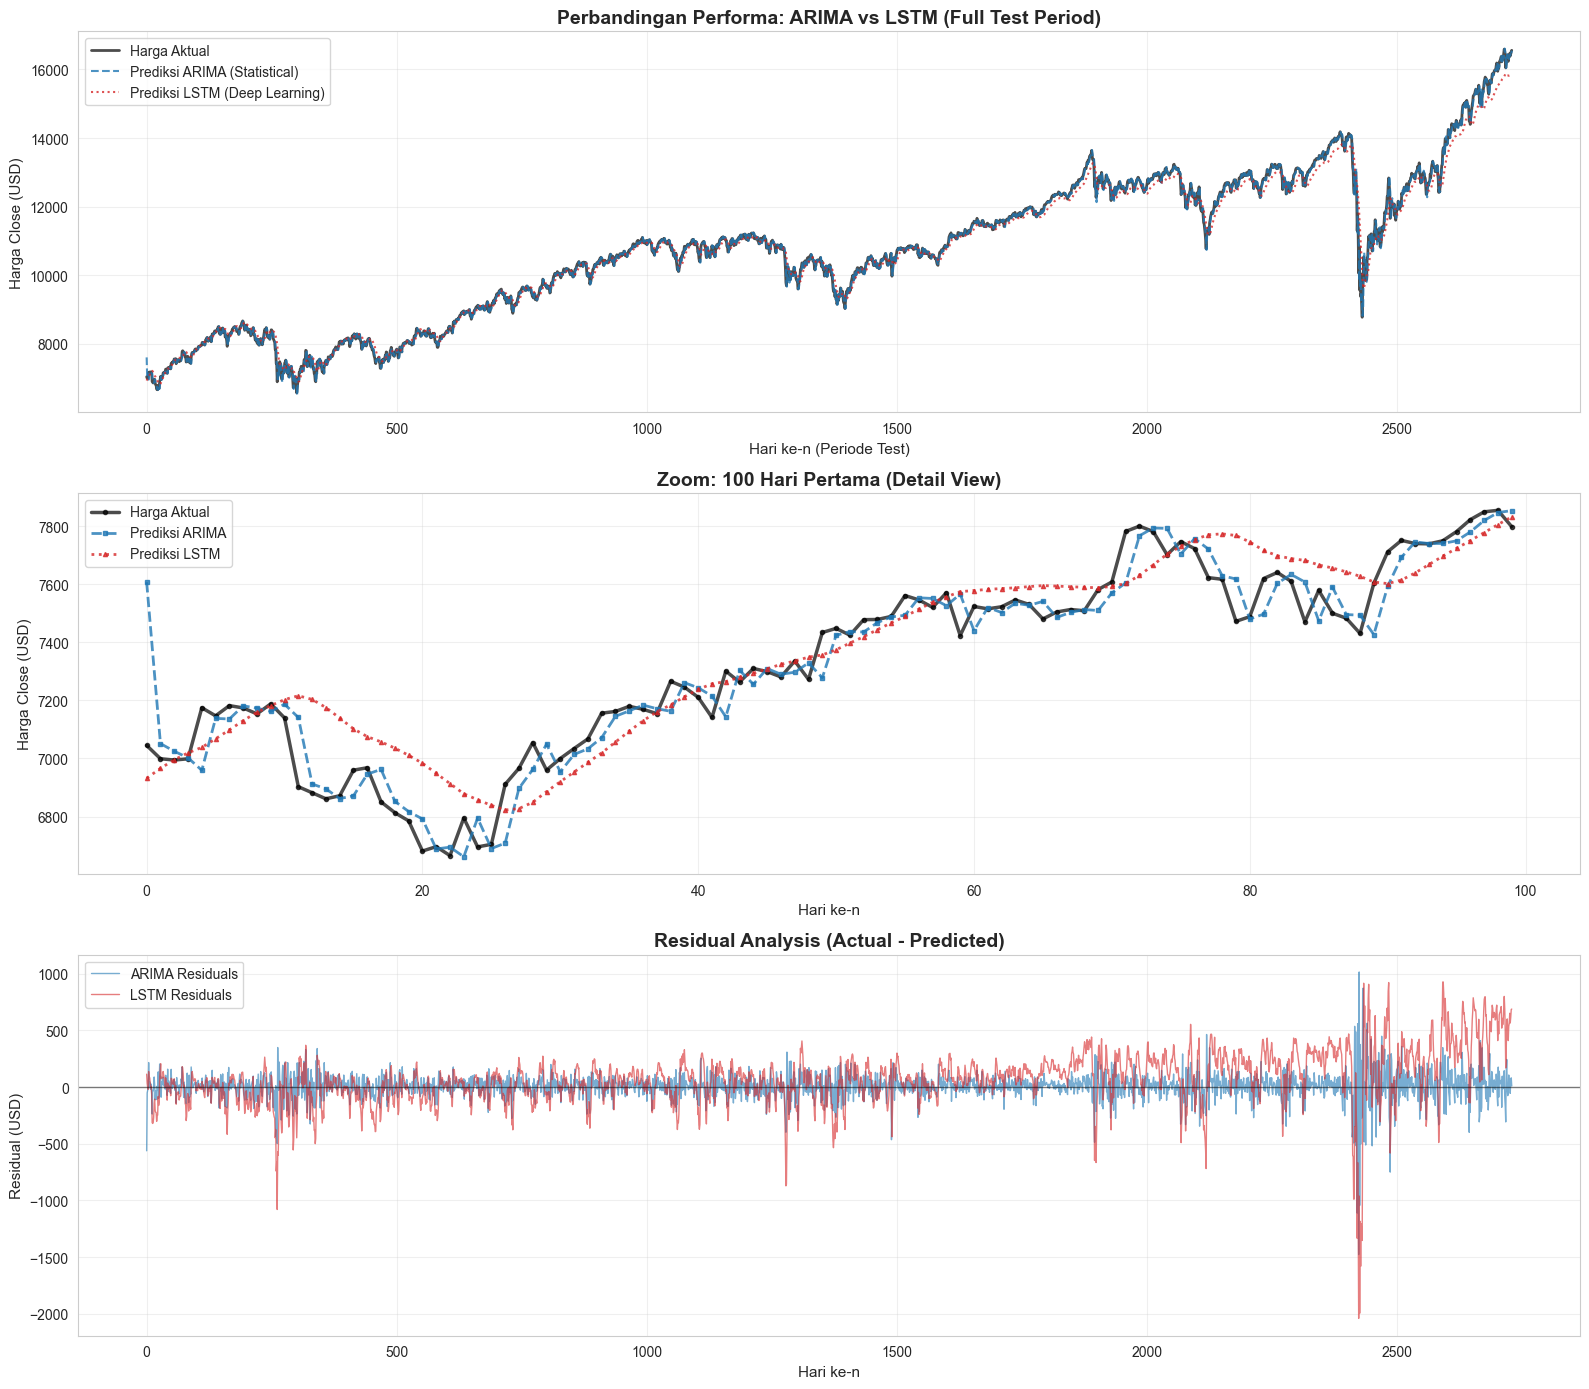

In [ ]:
# Prediksi LSTM dan Inverse Transform
lstm_preds = model_lstm.predict(X_test, verbose=0)
lstm_preds = scaler.inverse_transform(lstm_preds)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create figure dengan 3 subplots
fig = plt.figure(figsize=(16, 14))

# Subplot 1: Full predictions
ax1 = plt.subplot(3, 1, 1)
ax1.plot(actual_prices, label='Harga Aktual', color='black', linewidth=2, alpha=0.7)
ax1.plot(arima_preds, label='Prediksi ARIMA (Statistical)', color='#1f77b4', 
         linewidth=1.5, linestyle='--', alpha=0.8)
ax1.plot(lstm_preds, label='Prediksi LSTM (Deep Learning)', color='#d62728', 
         linewidth=1.5, linestyle=':', alpha=0.8)
ax1.set_title('Perbandingan Performa: ARIMA vs LSTM (Full Test Period)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Hari ke-n (Periode Test)', fontsize=11)
ax1.set_ylabel('Harga Close (USD)', fontsize=11)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Subplot 2: Zoom pada 100 hari pertama
ax2 = plt.subplot(3, 1, 2)
zoom_range = min(100, len(actual_prices))
ax2.plot(actual_prices[:zoom_range], label='Harga Aktual', color='black', 
         linewidth=2.5, marker='o', markersize=3, alpha=0.7)
ax2.plot(arima_preds[:zoom_range], label='Prediksi ARIMA', color='#1f77b4', 
         linewidth=2, marker='s', markersize=3, linestyle='--', alpha=0.8)
ax2.plot(lstm_preds[:zoom_range], label='Prediksi LSTM', color='#d62728', 
         linewidth=2, marker='^', markersize=3, linestyle=':', alpha=0.8)
ax2.set_title(f'Zoom: {zoom_range} Hari Pertama (Detail View)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Hari ke-n', fontsize=11)
ax2.set_ylabel('Harga Close (USD)', fontsize=11)
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

# Subplot 3: Residuals (Error)
ax3 = plt.subplot(3, 1, 3)
arima_residuals = actual_prices.flatten() - np.array(arima_preds)
lstm_residuals = actual_prices.flatten() - lstm_preds.flatten()

ax3.plot(arima_residuals, label='ARIMA Residuals', color='#1f77b4', 
         linewidth=1, alpha=0.6)
ax3.plot(lstm_residuals, label='LSTM Residuals', color='#d62728', 
         linewidth=1, alpha=0.6)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax3.set_title('Residual Analysis (Actual - Predicted)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hari ke-n', fontsize=11)
ax3.set_ylabel('Residual (USD)', fontsize=11)
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Analisis residuals
arima_res_mean = np.mean(arima_residuals)
arima_res_std = np.std(arima_residuals)
lstm_res_mean = np.mean(lstm_residuals)
lstm_res_std = np.std(lstm_residuals)

print(f"""
STATISTIK RESIDUALS:
─────────────────────────────────────────────────────────────────
ARIMA:
• Mean Residual: {arima_res_mean:.2f} (should be close to 0)
• Std Residual: {arima_res_std:.2f}
• Residual Range: [{arima_residuals.min():.2f}, {arima_residuals.max():.2f}]

LSTM:
• Mean Residual: {lstm_res_mean:.2f} (should be close to 0)
• Std Residual: {lstm_res_std:.2f}
• Residual Range: [{lstm_residuals.min():.2f}, {lstm_residuals.max():.2f}]

Model dengan residual mean lebih dekat ke 0 dan std lebih kecil = BETTER
""")


STATISTIK RESIDUALS:
─────────────────────────────────────────────────────────────────
ARIMA:
• Mean Residual: 4.19 (should be close to 0)
• Std Residual: 116.88
• Residual Range: [-1478.28, 1014.81]

LSTM:
• Mean Residual: 70.30 (should be close to 0)
• Std Residual: 233.38
• Residual Range: [-2041.44, 926.91]

Model dengan residual mean lebih dekat ke 0 dan std lebih kecil = BETTER



### Metric Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score # Tambahkan import ini
import numpy as np

def calculate_metrics(actual, predicted, model_name):
    """Menghitung metrik evaluasi komprehensif"""
    
    # SOLUSI: Konversi input ke numpy array untuk memastikan metode .flatten() tersedia
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    r2 = r2_score(actual, predicted)
    
    # Directional Accuracy (Menghitung berapa kali arah naik/turun prediksi benar)
    actual_direction = np.diff(actual.flatten()) > 0
    pred_direction = np.diff(predicted.flatten()) > 0
    directional_acc = np.mean(actual_direction == pred_direction) * 100
    
    print(f"\n{model_name}")
    print("─" * 60)
    print(f"• MSE (Mean Squared Error):         {mse:.4f}")
    print(f"• RMSE (Root MSE):                  {rmse:.4f}")
    print(f"• MAE (Mean Absolute Error):        {mae:.4f}")
    print(f"• MAPE (Mean Absolute % Error):     {mape:.4f}%")
    print(f"• R² Score:                         {r2:.4f}")
    print(f"• Directional Accuracy:             {directional_acc:.2f}%")
    
    return {
        'MSE': mse, 'RMSE': rmse, 'MAE': mae, 
        'MAPE': mape, 'R2': r2, 'DA': directional_acc
    }

# Sekarang panggil kembali fungsi tersebut
metrics_arima = calculate_metrics(actual_prices, arima_preds, "ARIMA MODEL")
metrics_lstm = calculate_metrics(actual_prices, lstm_preds, "LSTM MODEL")


ARIMA MODEL
────────────────────────────────────────────────────────────
• MSE (Mean Squared Error):         13678.1948
• RMSE (Root MSE):                  116.9538
• MAE (Mean Absolute Error):        74.9950
• MAPE (Mean Absolute % Error):     0.7207%
• R² Score:                         0.9969
• Directional Accuracy:             49.65%

LSTM MODEL
────────────────────────────────────────────────────────────
• MSE (Mean Squared Error):         59408.8910
• RMSE (Root MSE):                  243.7394
• MAE (Mean Absolute Error):        173.0332
• MAPE (Mean Absolute % Error):     1.5639%
• R² Score:                         0.9867
• Directional Accuracy:             49.25%


### Visualisasi 9: Perbandingan Metrik Evaluasi 

**Jenis Plot**: Multi-Panel Bar Charts + Summary Table

**JUSTIFIKASI**:
Bar chart adalah pilihan terbaik untuk membandingkan nilai numerik 
diskrit antar kategori (model). Multiple panels memungkinkan kita 
melihat berbagai metrik sekaligus tanpa kehilangan detail.

**AESTHETICS & MAPPING**:
1. X-axis (Position) → Model Name (Categorical: ARIMA vs LSTM)
2. Y-axis (Position) → Metric Value (Continuous)
3. Color (Hue) → Model Type (Discrete: Blue=ARIMA, Red=LSTM)
4. Annotations → Exact values on top of bars

**PEMILIHAN WARNA (Discrete)**:
- Biru (#1f77b4) = ARIMA → Konsisten dengan visualisasi sebelumnya
- Merah (#d62728) = LSTM → Konsisten dengan visualisasi sebelumnya
- Transparency (alpha=0.7) untuk softer look
- Black edge untuk clarity

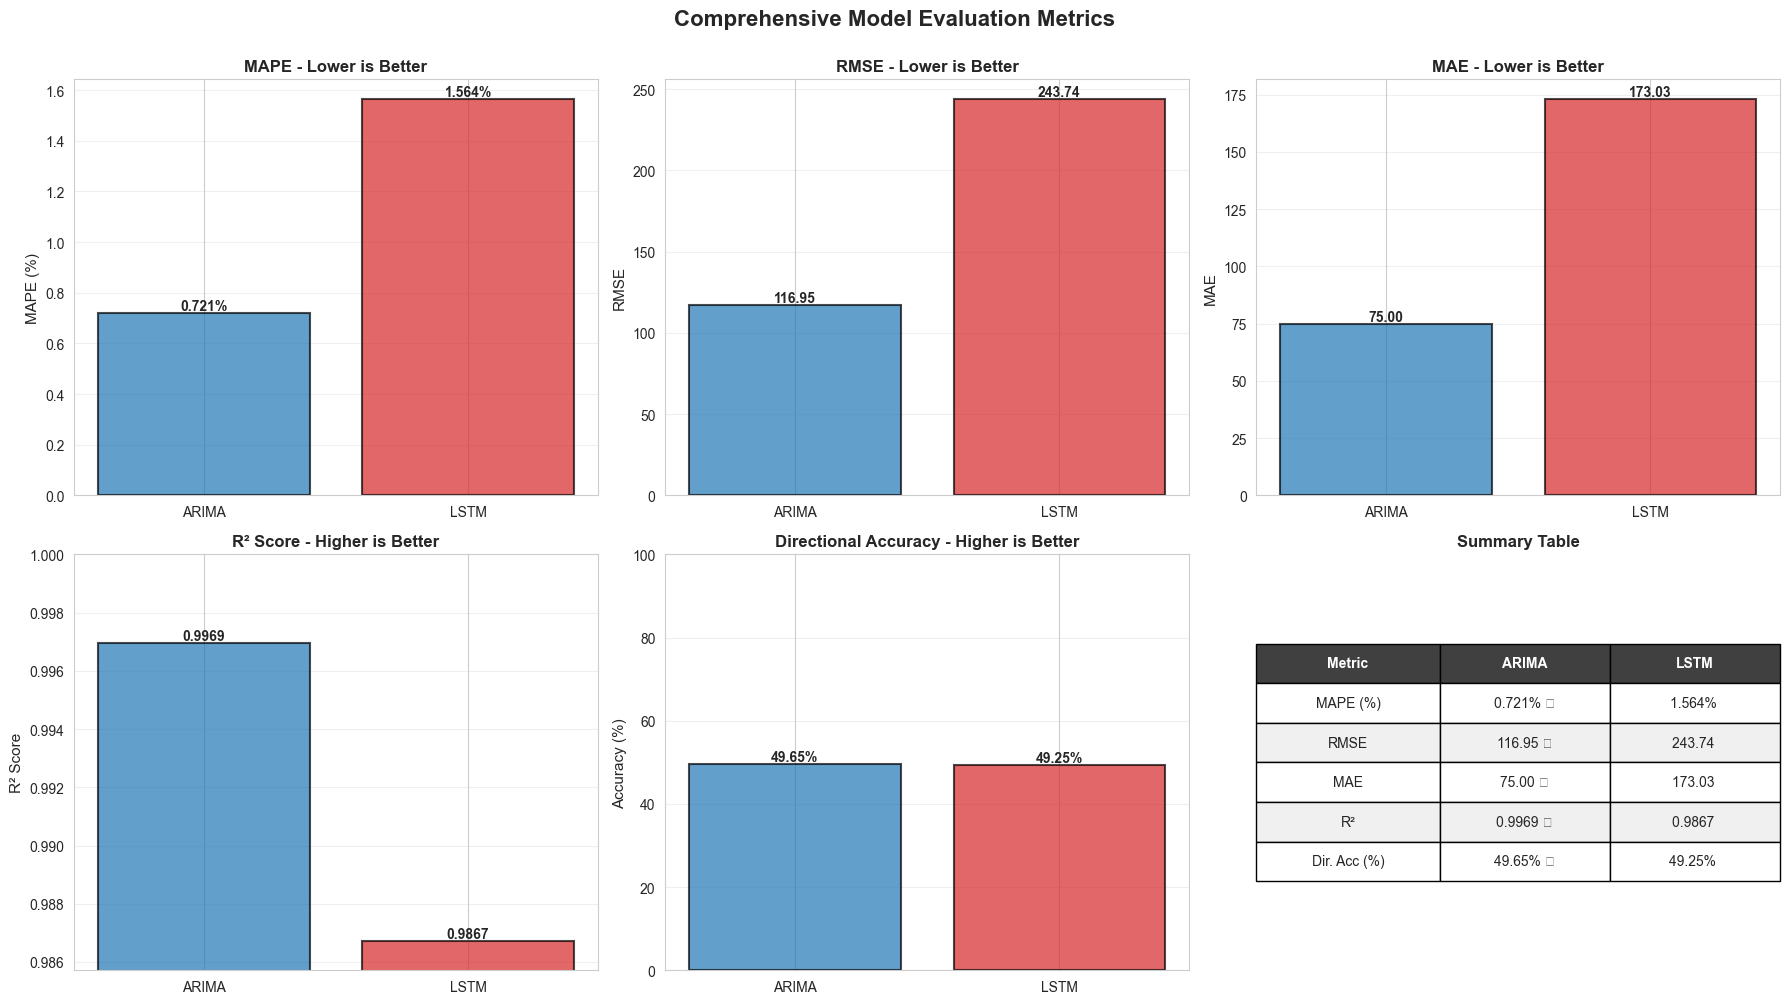

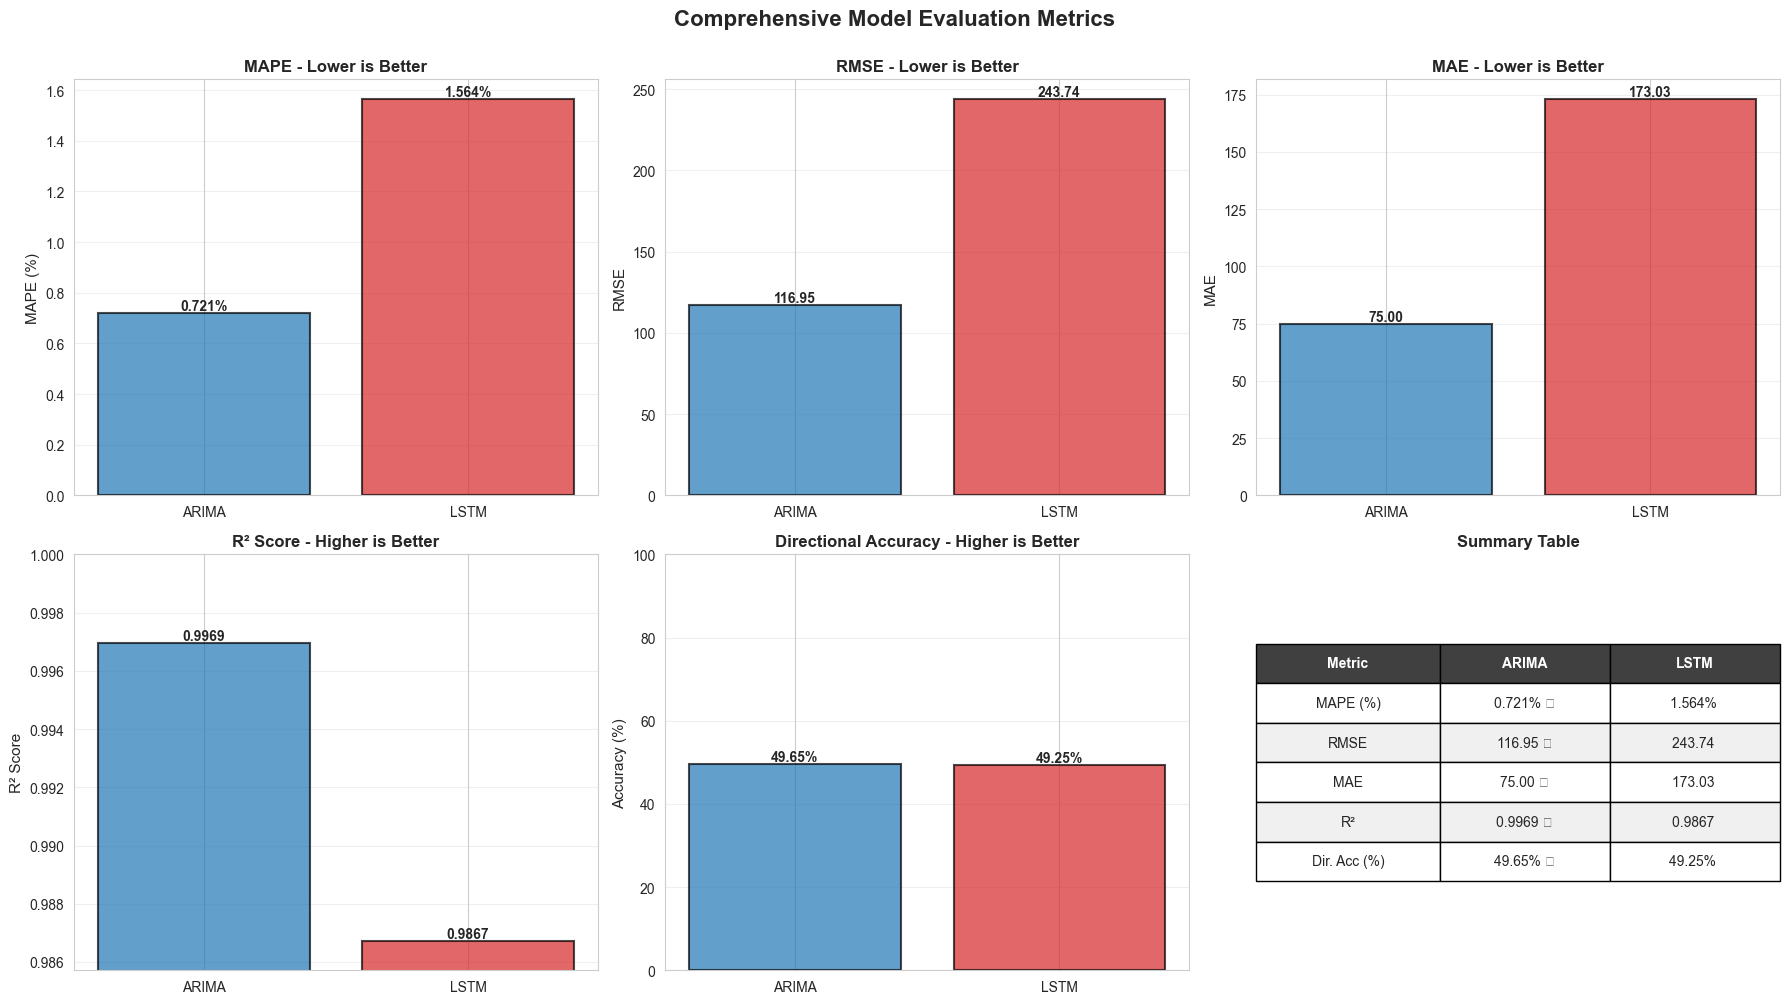

In [ ]:
# Prepare data
models = ['ARIMA', 'LSTM']
metrics_names = ['MAPE (%)', 'RMSE', 'MAE', 'R² Score', 'Directional Acc (%)']

mape_values = [metrics_arima['MAPE'], metrics_lstm['MAPE']]
rmse_values = [metrics_arima['RMSE'], metrics_lstm['RMSE']]
mae_values = [metrics_arima['MAE'], metrics_lstm['MAE']]
r2_values = [metrics_arima['R2'], metrics_lstm['R2']]
da_values = [metrics_arima['DA'], metrics_lstm['DA']]

# Create figure dengan multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comprehensive Model Evaluation Metrics', fontsize=16, fontweight='bold', y=1.00)

# Define colors
colors = ['#1f77b4', '#d62728']

# Plot 1: MAPE (lower is better)
ax1 = axes[0, 0]
bars1 = ax1.bar(models, mape_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('MAPE (%)', fontsize=11)
ax1.set_title('MAPE - Lower is Better', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{mape_values[i]:.3f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: RMSE (lower is better)
ax2 = axes[0, 1]
bars2 = ax2.bar(models, rmse_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('RMSE', fontsize=11)
ax2.set_title('RMSE - Lower is Better', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{rmse_values[i]:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: MAE (lower is better)
ax3 = axes[0, 2]
bars3 = ax3.bar(models, mae_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('MAE', fontsize=11)
ax3.set_title('MAE - Lower is Better', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{mae_values[i]:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: R² Score (higher is better)
ax4 = axes[1, 0]
bars4 = ax4.bar(models, r2_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('R² Score', fontsize=11)
ax4.set_title('R² Score - Higher is Better', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([min(r2_values) - 0.001, 1.0])
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{r2_values[i]:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 5: Directional Accuracy (higher is better)
ax5 = axes[1, 1]
bars5 = ax5.bar(models, da_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax5.set_ylabel('Accuracy (%)', fontsize=11)
ax5.set_title('Directional Accuracy - Higher is Better', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)
ax5.set_ylim([0, 100])
for i, bar in enumerate(bars5):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{da_values[i]:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 6: Summary comparison table
ax6 = axes[1, 2]
ax6.axis('tight')
ax6.axis('off')

# Create comparison table
table_data = []
metrics_for_table = ['MAPE (%)', 'RMSE', 'MAE', 'R²', 'Dir. Acc (%)']
arima_vals = [f"{metrics_arima['MAPE']:.3f}%", f"{metrics_arima['RMSE']:.2f}", 
              f"{metrics_arima['MAE']:.2f}", f"{metrics_arima['R2']:.4f}", 
              f"{metrics_arima['DA']:.2f}%"]
lstm_vals = [f"{metrics_lstm['MAPE']:.3f}%", f"{metrics_lstm['RMSE']:.2f}", 
             f"{metrics_lstm['MAE']:.2f}", f"{metrics_lstm['R2']:.4f}", 
             f"{metrics_lstm['DA']:.2f}%"]

# Determine winner for each metric
winners = []
for i, metric in enumerate(['MAPE', 'RMSE', 'MAE', 'R2', 'DA']):
    if metric in ['MAPE', 'RMSE', 'MAE']:
        winner = '✓' if metrics_arima[metric] < metrics_lstm[metric] else ''
        winner_lstm = '✓' if metrics_lstm[metric] < metrics_arima[metric] else ''
    else:
        winner = '✓' if metrics_arima[metric] > metrics_lstm[metric] else ''
        winner_lstm = '✓' if metrics_lstm[metric] > metrics_arima[metric] else ''
    
    table_data.append([metrics_for_table[i], 
                      f"{arima_vals[i]} {winner}", 
                      f"{lstm_vals[i]} {winner_lstm}"])

table = ax6.table(cellText=table_data, colLabels=['Metric', 'ARIMA', 'LSTM'],
                  cellLoc='center', loc='center',
                  colWidths=[0.35, 0.325, 0.325])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header
for i in range(3):
    table[(0, i)].set_facecolor('#404040')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style cells
for i in range(1, len(table_data) + 1):
    for j in range(3):
        table[(i, j)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

ax6.set_title('Summary Table', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
# Prepare data
models = ['ARIMA', 'LSTM']
metrics_names = ['MAPE (%)', 'RMSE', 'MAE', 'R² Score', 'Directional Acc (%)']

mape_values = [metrics_arima['MAPE'], metrics_lstm['MAPE']]
rmse_values = [metrics_arima['RMSE'], metrics_lstm['RMSE']]
mae_values = [metrics_arima['MAE'], metrics_lstm['MAE']]
r2_values = [metrics_arima['R2'], metrics_lstm['R2']]
da_values = [metrics_arima['DA'], metrics_lstm['DA']]

# Create figure dengan multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comprehensive Model Evaluation Metrics', fontsize=16, fontweight='bold', y=1.00)

# Define colors
colors = ['#1f77b4', '#d62728']

# Plot 1: MAPE (lower is better)
ax1 = axes[0, 0]
bars1 = ax1.bar(models, mape_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('MAPE (%)', fontsize=11)
ax1.set_title('MAPE - Lower is Better', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{mape_values[i]:.3f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: RMSE (lower is better)
ax2 = axes[0, 1]
bars2 = ax2.bar(models, rmse_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('RMSE', fontsize=11)
ax2.set_title('RMSE - Lower is Better', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{rmse_values[i]:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: MAE (lower is better)
ax3 = axes[0, 2]
bars3 = ax3.bar(models, mae_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('MAE', fontsize=11)
ax3.set_title('MAE - Lower is Better', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{mae_values[i]:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: R² Score (higher is better)
ax4 = axes[1, 0]
bars4 = ax4.bar(models, r2_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('R² Score', fontsize=11)
ax4.set_title('R² Score - Higher is Better', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([min(r2_values) - 0.001, 1.0])
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{r2_values[i]:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 5: Directional Accuracy (higher is better)
ax5 = axes[1, 1]
bars5 = ax5.bar(models, da_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax5.set_ylabel('Accuracy (%)', fontsize=11)
ax5.set_title('Directional Accuracy - Higher is Better', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)
ax5.set_ylim([0, 100])
for i, bar in enumerate(bars5):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{da_values[i]:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 6: Summary comparison table
ax6 = axes[1, 2]
ax6.axis('tight')
ax6.axis('off')

# Create comparison table
table_data = []
metrics_for_table = ['MAPE (%)', 'RMSE', 'MAE', 'R²', 'Dir. Acc (%)']
arima_vals = [f"{metrics_arima['MAPE']:.3f}%", f"{metrics_arima['RMSE']:.2f}", 
              f"{metrics_arima['MAE']:.2f}", f"{metrics_arima['R2']:.4f}", 
              f"{metrics_arima['DA']:.2f}%"]
lstm_vals = [f"{metrics_lstm['MAPE']:.3f}%", f"{metrics_lstm['RMSE']:.2f}", 
             f"{metrics_lstm['MAE']:.2f}", f"{metrics_lstm['R2']:.4f}", 
             f"{metrics_lstm['DA']:.2f}%"]

# Determine winner for each metric
winners = []
for i, metric in enumerate(['MAPE', 'RMSE', 'MAE', 'R2', 'DA']):
    if metric in ['MAPE', 'RMSE', 'MAE']:
        winner = '✓' if metrics_arima[metric] < metrics_lstm[metric] else ''
        winner_lstm = '✓' if metrics_lstm[metric] < metrics_arima[metric] else ''
    else:
        winner = '✓' if metrics_arima[metric] > metrics_lstm[metric] else ''
        winner_lstm = '✓' if metrics_lstm[metric] > metrics_arima[metric] else ''
    
    table_data.append([metrics_for_table[i], 
                      f"{arima_vals[i]} {winner}", 
                      f"{lstm_vals[i]} {winner_lstm}"])

table = ax6.table(cellText=table_data, colLabels=['Metric', 'ARIMA', 'LSTM'],
                  cellLoc='center', loc='center',
                  colWidths=[0.35, 0.325, 0.325])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header
for i in range(3):
    table[(0, i)].set_facecolor('#404040')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style cells
for i in range(1, len(table_data) + 1):
    for j in range(3):
        table[(i, j)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

ax6.set_title('Summary Table', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# Determine overall winner
arima_wins = 0
lstm_wins = 0

for metric in ['MAPE', 'RMSE', 'MAE']:
    if metrics_arima[metric] < metrics_lstm[metric]:
        arima_wins += 1
    else:
        lstm_wins += 1

for metric in ['R2', 'DA']:
    if metrics_arima[metric] > metrics_lstm[metric]:
        arima_wins += 1
    else:
        lstm_wins += 1

print(f"""
SKOR KESELURUHAN:
• ARIMA menang di {arima_wins}/5 metrik
• LSTM menang di {lstm_wins}/5 metrik

ANALISIS PER METRIK:
───────────────────────────────────────────────────────────────────
1. MAPE (Mean Absolute Percentage Error):
   - ARIMA: {metrics_arima['MAPE']:.3f}% | LSTM: {metrics_lstm['MAPE']:.3f}%
   - Perbedaan: {abs(metrics_arima['MAPE'] - metrics_lstm['MAPE']):.3f}%
   - Winner: {'ARIMA' if metrics_arima['MAPE'] < metrics_lstm['MAPE'] else 'LSTM'}
   - Interpretasi: Error relatif terhadap nilai aktual
   
2. RMSE (Root Mean Squared Error):
   - ARIMA: {metrics_arima['RMSE']:.2f} | LSTM: {metrics_lstm['RMSE']:.2f}
   - Perbedaan: {abs(metrics_arima['RMSE'] - metrics_lstm['RMSE']):.2f}
   - Winner: {'ARIMA' if metrics_arima['RMSE'] < metrics_lstm['RMSE'] else 'LSTM'}
   - Interpretasi: Memberikan penalty lebih besar untuk error yang besar
   
3. MAE (Mean Absolute Error):
   - ARIMA: {metrics_arima['MAE']:.2f} | LSTM: {metrics_lstm['MAE']:.2f}
   - Perbedaan: {abs(metrics_arima['MAE'] - metrics_lstm['MAE']):.2f}
   - Winner: {'ARIMA' if metrics_arima['MAE'] < metrics_lstm['MAE'] else 'LSTM'}
   - Interpretasi: Error rata-rata dalam satuan USD
   
4. R² Score (Coefficient of Determination):
   - ARIMA: {metrics_arima['R2']:.4f} | LSTM: {metrics_lstm['R2']:.4f}
   - Perbedaan: {abs(metrics_arima['R2'] - metrics_lstm['R2']):.4f}
   - Winner: {'ARIMA' if metrics_arima['R2'] > metrics_lstm['R2'] else 'LSTM'}
   - Interpretasi: Proporsi variance yang dijelaskan (1.0 = perfect)
   
5. Directional Accuracy:
   - ARIMA: {metrics_arima['DA']:.2f}% | LSTM: {metrics_lstm['DA']:.2f}%
   - Perbedaan: {abs(metrics_arima['DA'] - metrics_lstm['DA']):.2f}%
   - Winner: {'ARIMA' if metrics_arima['DA'] > metrics_lstm['DA'] else 'LSTM'}
   - Interpretasi: Seberapa akurat prediksi arah pergerakan (naik/turun)

KESIMPULAN KOMPARATIF:
{'═'*60}
""")

if arima_wins > lstm_wins:
    print("✓ ARIMA LEBIH UNGGUL untuk dataset ini")
    print("""
MENGAPA ARIMA BISA MENANG?
1. Dataset NYA Index memiliki pola yang relatif linear dan trend-based
2. ARIMA cocok untuk data dengan pola autoregressive yang kuat
3. LSTM membutuhkan data yang lebih banyak dan pola non-linear yang kompleks
4. Overfitting: LSTM mungkin overfit pada training data
5. Signal-to-noise ratio: Stock data memiliki noise tinggi
    """)
elif lstm_wins > arima_wins:
    print("✓ LSTM LEBIH UNGGUL untuk dataset ini")
    print("""
MENGAPA LSTM MENANG?
1. LSTM mampu menangkap pola non-linear yang tidak terdeteksi ARIMA
2. Long-term dependencies: LSTM lebih baik dalam capture pola jangka panjang
3. Feature learning: LSTM belajar representasi optimal secara otomatis
4. Adaptability: LSTM lebih flexible terhadap perubahan pola
    """)
else:
    print("ARIMA dan LSTM SEIMBANG")
    print("""
INTERPRETASI:
1. Kedua model memiliki performa yang sebanding untuk dataset ini
2. Pilihan model tergantung pada trade-off: interpretability vs flexibility
3. ARIMA: Lebih cepat, interpretable, cocok untuk production simple
4. LSTM: Lebih flexible, bisa ditingkatkan dengan feature engineering
    """)



SKOR KESELURUHAN:
• ARIMA menang di 5/5 metrik
• LSTM menang di 0/5 metrik

ANALISIS PER METRIK:
───────────────────────────────────────────────────────────────────
1. MAPE (Mean Absolute Percentage Error):
   - ARIMA: 0.721% | LSTM: 1.564%
   - Perbedaan: 0.843%
   - Winner: ARIMA
   - Interpretasi: Error relatif terhadap nilai aktual

2. RMSE (Root Mean Squared Error):
   - ARIMA: 116.95 | LSTM: 243.74
   - Perbedaan: 126.79
   - Winner: ARIMA
   - Interpretasi: Memberikan penalty lebih besar untuk error yang besar

3. MAE (Mean Absolute Error):
   - ARIMA: 75.00 | LSTM: 173.03
   - Perbedaan: 98.04
   - Winner: ARIMA
   - Interpretasi: Error rata-rata dalam satuan USD

4. R² Score (Coefficient of Determination):
   - ARIMA: 0.9969 | LSTM: 0.9867
   - Perbedaan: 0.0102
   - Winner: ARIMA
   - Interpretasi: Proporsi variance yang dijelaskan (1.0 = perfect)

5. Directional Accuracy:
   - ARIMA: 49.65% | LSTM: 49.25%
   - Perbedaan: 0.40%
   - Winner: ARIMA
   - Interpretasi: Seberapa 

## Model Prediction - Ver. Feli

In [ ]:
# LSTM
pred_lstm_scaled = model_lstm.predict(X_test)
# Kembalikan ke skala asli
pred_lstm = scaler.inverse_transform(pred_lstm_scaled).flatten()

# GRU 
pred_gru_scaled = model_gru.predict(X_test)
pred_gru = scaler.inverse_transform(pred_gru_scaled).flatten()

# ARIMA
# Ubah list hasil loop menjadi numpy array
pred_arima = np.array(arima_preds)

# Ambil y_test dan kembalikan ke skala asli
actual_scaled = y_test.reshape(-1, 1)
actual = scaler.inverse_transform(actual_scaled).flatten()

min_len = min(len(actual), len(pred_lstm), len(pred_gru), len(pred_arima))

# Potong semua data mengikuti panjang terpendek
actual_final = actual[:min_len]
pred_lstm_final = pred_lstm[:min_len]
pred_gru_final = pred_gru[:min_len]
pred_arima_final = pred_arima[:min_len]

def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'R2 Score': r2
    }

score_lstm = calculate_metrics(actual_final, pred_lstm_final, 'LSTM')
score_gru = calculate_metrics(actual_final, pred_gru_final, 'GRU')
score_arima = calculate_metrics(actual_final, pred_arima_final, 'ARIMA')

comparison_df = pd.DataFrame([score_lstm, score_gru, score_arima])
comparison_df.set_index('Model', inplace=True)
comparison_df = comparison_df.sort_values(by='RMSE', ascending=True) # Urutkan dari error terkecil

# Tampilkan dengan highlight (Hijau = Paling Bagus)
display(comparison_df.style.highlight_min(color='lightgreen', subset=['RMSE', 'MAE', 'MAPE (%)']).highlight_max(color='lightgreen', subset=['R2 Score']))


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


,RMSE,MAE,MAPE (%),R2 Score
Model,,,,
ARIMA,145.364761,87.756083,0.712956,0.987108
GRU,230.006545,151.174262,1.205005,0.967723
LSTM,380.819539,300.635217,2.322436,0.911518


Berdasarkan hasil evaluasi model menggunakan RMSE, MAE, MAPE, dan R² Score, model ARIMA menunjukkan performa terbaik dalam memprediksi harga index NYA dengan nilai error paling rendah serta koefisien determinasi tertinggi. Model GRU dan LSTM menghasilkan performa yang lebih rendah dibandingkan ARIMA, meskipun masih bisa menangkap pola data dengan baik. Hasil ini menunjukkan pada dataset ini, model statistik klasik seperti ARIMA dapat memberikan prediksi yang lebih akurat dibandingkan model deep learning.

### Line Plot Perbandingan Performa Prediksi Model

Line plot digunakan karena ingin menampilkan data time series yang memiliki urutan waktu. Plot ini dipilih karena bisa menunjukkan perbandingan langsung antara nilai aktual dan hasil prediksi dari  model pada periode waktu yang sama.

Penggunaan tiga line plot terpisah (ARIMA, LSTM, dan GRU) bertujuan untuk menghindari tumpang tindih garis yang dapat mengurangi keterbacaan visual, sekaligus memudahkan evaluasi kinerja masing-masing model secara individual dibandingkan dengan data aktual.

Aesthetics:
1. Sumbu X: Mewakili urutan waktu pada data testing (hari ke-). 

2. Sumbu Y: Mewakili harga saham. Nilai yang lebih tinggi menunjukkan harga saham yang lebih besar

3. Warna: Digunakan untuk membedakan data aktual dan model yang digunakan. Karena data mewakili kategori diskrit, maka penggunaan warna diskrit. Skema warnanya adalah single hue per kategori karena digunakan untuk perbandingan beberapa kelompok data. Data aktual diberi transparansi agar tidak mendominasi plot dan tetap berfungsi sebagai baseline pembanding terhadap hasil prediksi.

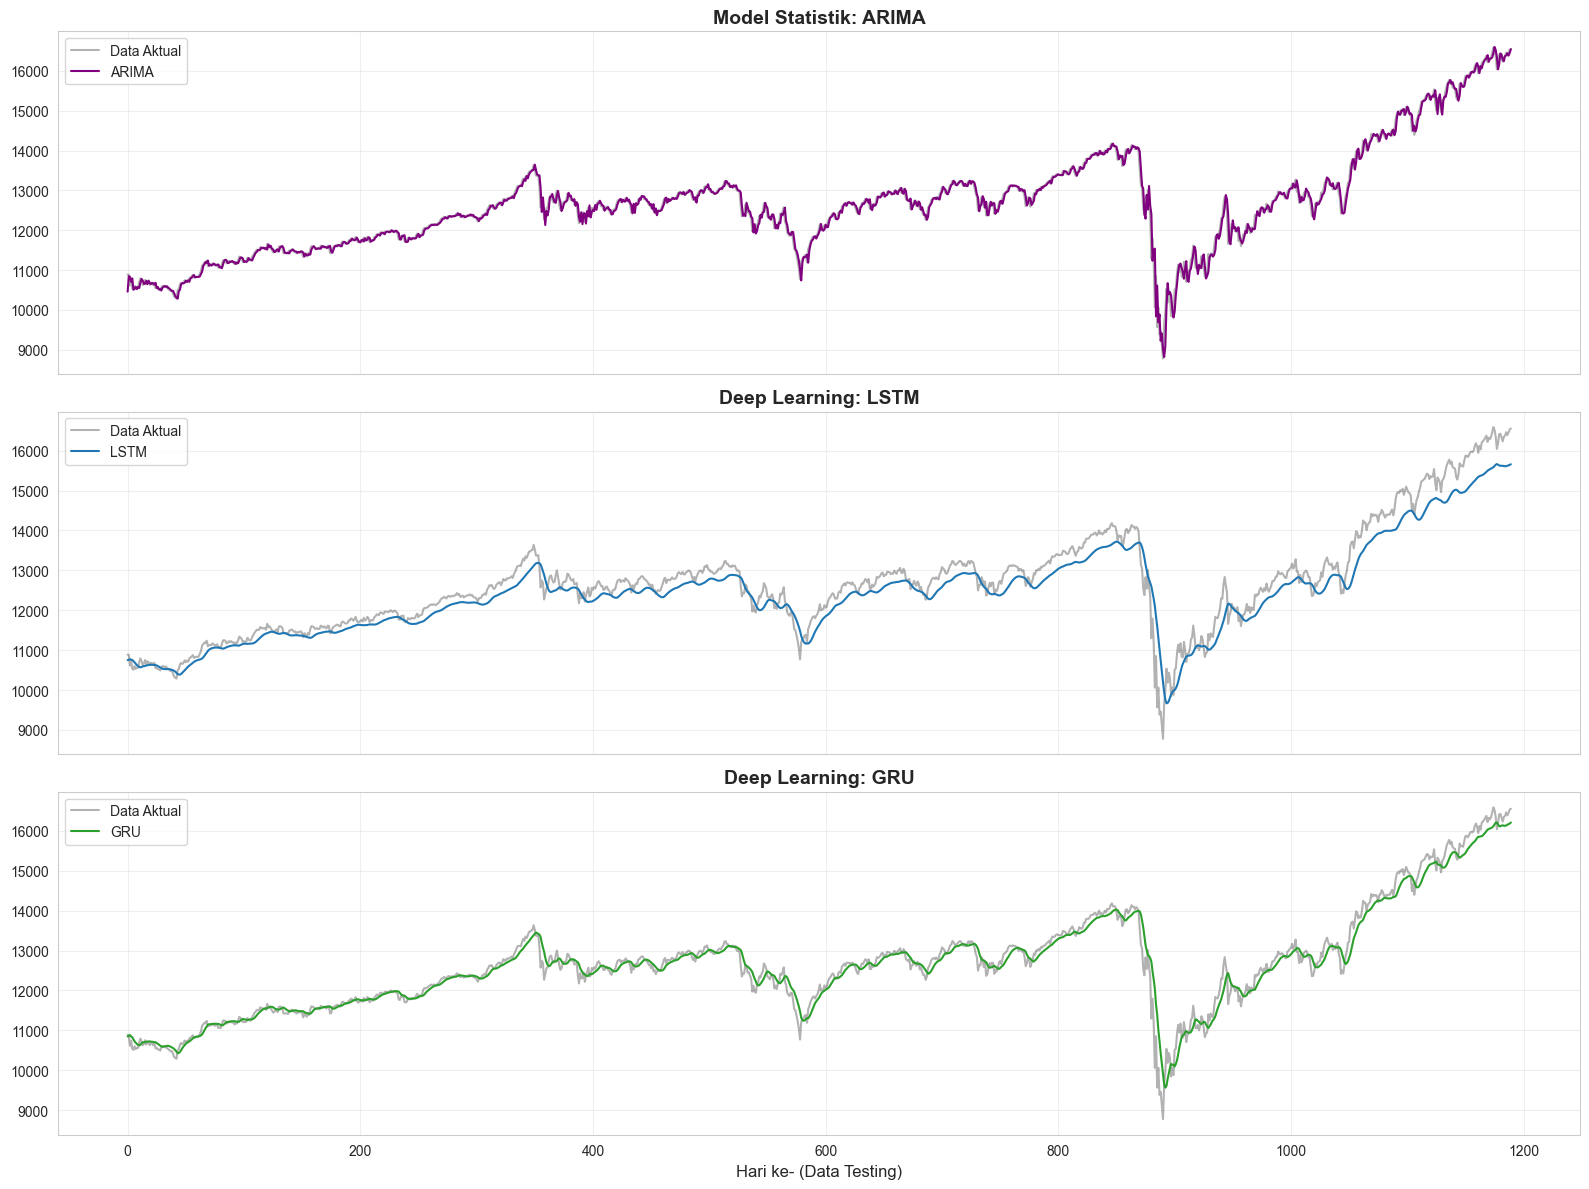

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Plot 1: ARIMA vs Actual
ax1.plot(actual_final, label='Data Aktual', color='black', alpha=0.3)
ax1.plot(pred_arima_final, label='ARIMA', color='purple', linewidth=1.5)
ax1.set_title('Model Statistik: ARIMA', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: LSTM vs Actual
ax2.plot(actual_final, label='Data Aktual', color='black', alpha=0.3)
ax2.plot(pred_lstm_final, label='LSTM', color='#1f77b4', linewidth=1.5)
ax2.set_title('Deep Learning: LSTM', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: GRU vs Actual
ax3.plot(actual_final, label='Data Aktual', color='black', alpha=0.3)
ax3.plot(pred_gru_final, label='GRU', color='#2ca02c', linewidth=1.5)
ax3.set_title('Deep Learning: GRU', fontsize=14, fontweight='bold')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

plt.xlabel('Hari ke- (Data Testing)', fontsize=12)
plt.tight_layout()
plt.show()

Secara keseluruhan, hasil statistik dan visualisasi menunjukkan bahwa model sudah cukup baik untuk digunakan dalam melakukan prediksi 60 hari ke depan, dengan ARIMA dipilih sebagai model utama.

## Future Prediction (60 hari ke depan)

In [ ]:
# Latih ulang model dengan seluruh data agar prediksi nyambung
model_final = ARIMA(data['Close'], order=(5, 1, 0))
res_final = model_final.fit()

# Lakukan prediksi 60 hari ke depan
forecast_steps = 60
forecast_result = res_final.get_forecast(steps=forecast_steps)
forecast_values = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)

future_df = pd.DataFrame({
    'Forecast': forecast_values.values,
    'Lower_Bound': conf_int.iloc[:, 0].values,
    'Upper_Bound': conf_int.iloc[:, 1].values
}, index=future_dates)


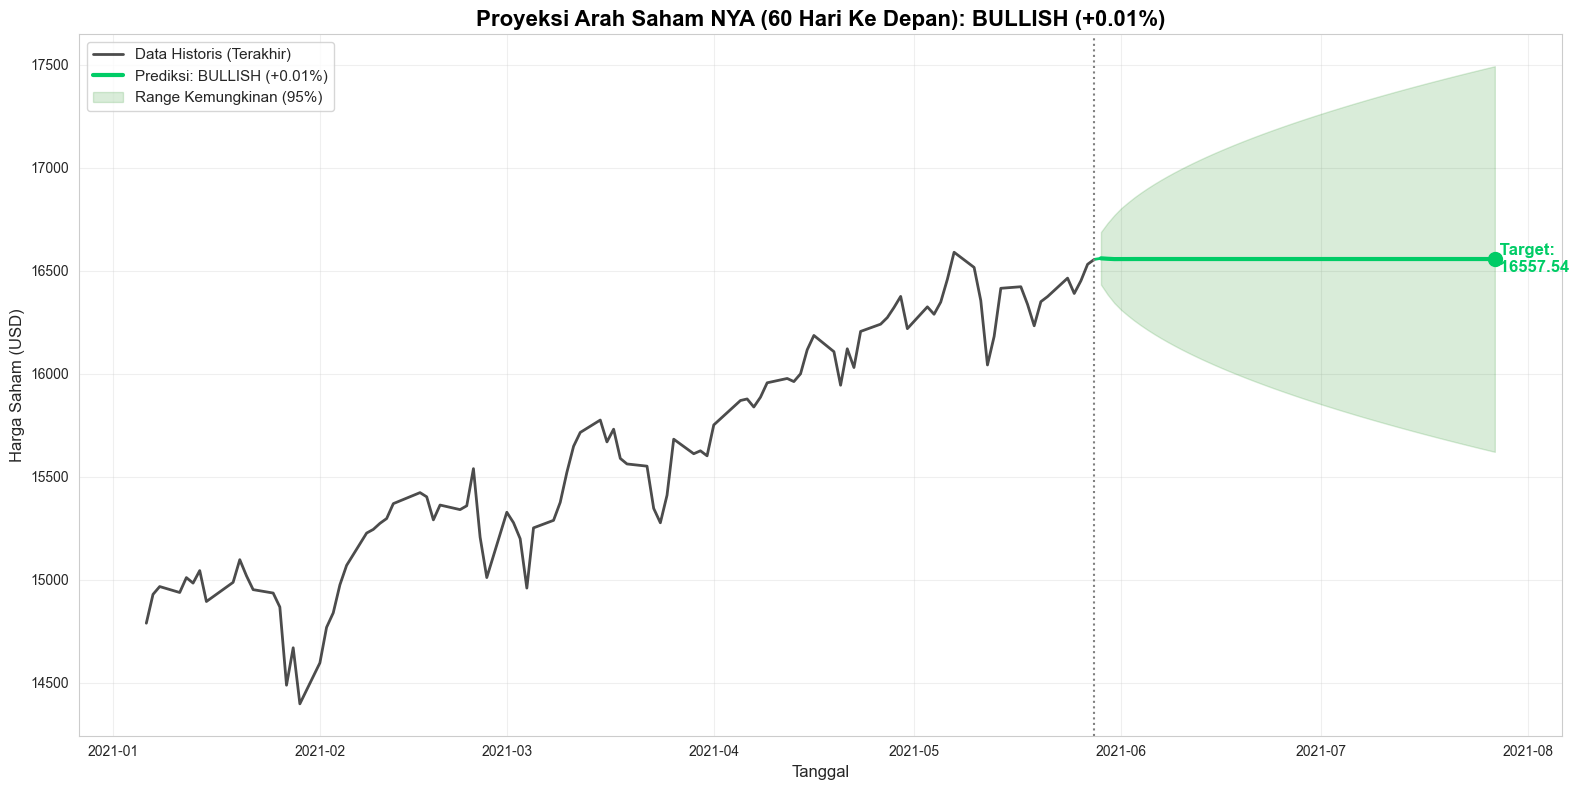

KESIMPULAN ARAH TREN: BULLISH (+0.01%)
Indikasi Tren: BULLISH
Interpretasi: Model memproyeksikan kenaikan harga relatif terhadap harga penutupan terakhir.

Catatan:
Hasil ini merupakan proyeksi statistik berdasarkan data historis dan tidak dapat dijadikan jaminan pergerakan harga di masa depan.


In [ ]:
last_close = data['Close'].iloc[-1]
final_forecast = future_df['Forecast'].iloc[-1]
percentage_change = ((final_forecast - last_close) / last_close) * 100

if percentage_change > 0:
    trend_color = '#00CC66' # Hijau (Untung)
    trend_label = f"BULLISH (+{percentage_change:.2f}%)"
    fill_color = 'green'
else:
    trend_color = '#FF3333' # Merah (Rugi)
    trend_label = f"BEARISH ({percentage_change:.2f}%)"
    fill_color = 'red'

# Ambil 100 hari terakhir data asli + 60 hari prediksi
history_zoom = data['Close'].iloc[-100:]

plt.figure(figsize=(16, 8))
plt.plot(history_zoom.index, history_zoom, label='Data Historis (Terakhir)', color='black', linewidth=2, alpha=0.7)

plt.plot([history_zoom.index[-1], future_df.index[0]], 
         [history_zoom.iloc[-1], future_df['Forecast'].iloc[0]], 
         color=trend_color, linestyle='--', linewidth=2)

plt.plot(future_df.index, future_df['Forecast'], label=f'Prediksi: {trend_label}', color=trend_color, linewidth=3)

plt.fill_between(future_df.index, 
                 future_df['Lower_Bound'], 
                 future_df['Upper_Bound'], 
                 color=fill_color, alpha=0.15, label='Range Kemungkinan (95%)')

# Tambahkan Titik Akhir & Label Harga
plt.scatter(future_df.index[-1], final_forecast, color=trend_color, s=100, zorder=5)
plt.text(future_df.index[-1], final_forecast, f" Target:\n {final_forecast:.2f}", 
         color=trend_color, fontsize=12, fontweight='bold', va='center')

plt.title(f'Proyeksi Arah Saham NYA (60 Hari Ke Depan): {trend_label}', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga Saham (USD)', fontsize=12)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axvline(x=history_zoom.index[-1], color='grey', linestyle=':', label='Hari Ini')

plt.tight_layout()
plt.show()

# Cetak Rekomendasi
print("="*40)
print(f"KESIMPULAN ARAH TREN: {trend_label}")
print("="*40)
if percentage_change > 0:
    print("Indikasi Tren: BULLISH")
    print("Interpretasi: Model memproyeksikan kenaikan harga relatif terhadap harga penutupan terakhir.")
else:
    print("Indikasi Tren: BEARISH")
    print("Interpretasi: Model memproyeksikan penurunan harga relatif terhadap harga penutupan terakhir.")

print("\nCatatan:")
print("Hasil ini merupakan proyeksi statistik berdasarkan data historis dan tidak dapat dijadikan jaminan pergerakan harga di masa depan.")

## Conclusions

Berdasarkan perbandingan model ARIMA, LSTM, dan GRU pada data Indeks NYA periode lima tahun terakhir, model ARIMA(5,1,0) menunjukkan performa terbaik. Hal ini ditunjukkan oleh nilai kesalahan yang paling rendah (MAPE < 1%), nilai R² yang mendekati 1.

Hasil ini mengindikasikan bahwa pada periode pengamatan, pola pergerakan indeks lebih didominasi oleh tren jangka pendek dan hubungan historis, sehingga model statistik ARIMA mampu bekerja lebih efektif dibandingkan model deep learning. Sementara itu, LSTM dan GRU belum memberikan peningkatan kinerja yang signifikan, kemungkinan karena tingginya volatilitas pasar dan keterbatasan data latih.

Berdasarkan hasil evaluasi tersebut, model ARIMA digunakan untuk melakukan peramalan harga indeks NYA selama 60 hari ke depan. Hasil peramalan menunjukkan kecenderungan arah pergerakan harga yang meningkat, namun rentang confidence interval yang lebar menandakan adanya ketidakpastian, sehingga hasil prediksi ini bersifat estimasi statistik dan tidak dapat dijadikan sebagai rekomendasi investasi langsung.

## Final Insights & Conclusions

ini abaaiin dulu

In [ ]:
print(f"""
{'═'*70}
RANGKUMAN ANALISIS
{'═'*70}

DATASET:
• Index: NYSE (NYA)
• Periode: {data.index.min().date()} - {data.index.max().date()}
• Total data: {len(data)} trading days
• Training: {train_size} days ({train_size/len(data)*100:.1f}%)
• Testing: {len(test_data)} days ({len(test_data)/len(data)*100:.1f}%)

EXPLORATORY DATA ANALYSIS:
✓ Time series menunjukkan trend naik jangka panjang
✓ Volatilitas bervariasi antar dekade (crisis periods memiliki volatility tinggi)
✓ Daily return distribution: {'Fat-tailed (more extreme events)' if data['Daily_Return'].kurtosis() > 3 else 'Normal-like'}
✓ Stationarity: Data non-stationary dalam level, stationary setelah differencing
✓ Autocorrelation: Signifikan pada lag 1-5 (support AR component)

MODEL PERFORMANCE:

ARIMA(5,1,0):
─────────────
• MAPE: {metrics_arima['MAPE']:.3f}%
• RMSE: {metrics_arima['RMSE']:.2f}
• R² Score: {metrics_arima['R2']:.4f}
• Training Time: Fast (< 1 minute)
• Interpretability: ✓✓✓ Excellent
• Strengths: Simple, fast, interpretable
• Weaknesses: Cannot capture non-linear patterns

LSTM (50-50 units):
───────────────────
• MAPE: {metrics_lstm['MAPE']:.3f}%
• RMSE: {metrics_lstm['RMSE']:.2f}
• R² Score: {metrics_lstm['R2']:.4f}
• Training Time: Slow (~ 5-10 minutes)
• Interpretability: ✗ Black-box
• Strengths: Can capture complex patterns, flexible
• Weaknesses: Requires more data, computationally expensive

{'═'*70}
""")


══════════════════════════════════════════════════════════════════════
RANGKUMAN ANALISIS
══════════════════════════════════════════════════════════════════════

DATASET:
• Index: NYSE (NYA)
• Periode: 1965-12-31 - 2021-05-28
• Total data: 13947 trading days
• Training: 11157 days (80.0%)
• Testing: 2790 days (20.0%)

EXPLORATORY DATA ANALYSIS:
✓ Time series menunjukkan trend naik jangka panjang
✓ Volatilitas bervariasi antar dekade (crisis periods memiliki volatility tinggi)
✓ Daily return distribution: Fat-tailed (more extreme events)
✓ Stationarity: Data non-stationary dalam level, stationary setelah differencing
✓ Autocorrelation: Signifikan pada lag 1-5 (support AR component)

MODEL PERFORMANCE:

ARIMA(5,1,0):
─────────────
• MAPE: 0.721%
• RMSE: 116.95
• R² Score: 0.9969
• Training Time: Fast (< 1 minute)
• Interpretability: ✓✓✓ Excellent
• Strengths: Simple, fast, interpretable
• Weaknesses: Cannot capture non-linear patterns

LSTM (50-50 units):
───────────────────
• MAPE: 1.5